#Load Liabraries

In [343]:
%reset -f

In [344]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [345]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [346]:
import time
import math
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
get_ipython().run_line_magic('matplotlib', 'inline')

import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import make_scorer

#Load Dataset

In [347]:
train_data = pd.read_csv(r"C:\Users\jamil\OneDrive\Documents\University of Huddersfield\Individual Project\Dataset\rossmann-store-sales\train.csv", low_memory=False)
test_data = pd.read_csv(r"C:\Users\jamil\OneDrive\Documents\University of Huddersfield\Individual Project\Dataset\rossmann-store-sales\test.csv", low_memory=False)
store_data = pd.read_csv(r"C:\Users\jamil\OneDrive\Documents\University of Huddersfield\Individual Project\Dataset\rossmann-store-sales\store.csv")

In [348]:
train_data.Date = pd.to_datetime(train_data.Date)
test_data.Date = pd.to_datetime(test_data.Date)

In [349]:
train_data.head(5)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [350]:
train_data.describe().T

count                           mean                  min  \
Store          1017209.0                     558.429727                  1.0   
DayOfWeek      1017209.0                       3.998341                  1.0   
Date             1017209  2014-04-11 01:30:42.846061824  2013-01-01 00:00:00   
Sales          1017209.0                    5773.818972                  0.0   
Customers      1017209.0                     633.145946                  0.0   
Open           1017209.0                       0.830107                  0.0   
Promo          1017209.0                       0.381515                  0.0   
SchoolHoliday  1017209.0                       0.178647                  0.0   

                               25%                  50%                  75%  \
Store                        280.0                558.0                838.0   
DayOfWeek                      2.0                  4.0                  6.0   
Date           2013-08-17 00:00:00  2014-04-02 00:00:00  2014-12-12 00:00:00   
Sales                       3727.0               5744.0               7856.0   
Customers                    405.0                609.0                837.0   
Open                           1.0                  1.0                  1.0   
Promo                          0.0                  0.0                  1.0   
SchoolHoliday                  0.0                  0.0                  0.0   

                               max          std  
Store                       1115.0   321.908651  
DayOfWeek                      7.0     1.997391  
Date           2015-07-31 00:00:00          NaN  
Sales                      41551.0  3849.926175  
Customers                   7388.0   464.411734  
Open                           1.0     0.375539  
Promo                          1.0     0.485759  
SchoolHoliday                  1.0     0.383056

In [351]:
train_data.shape

(1017209, 9)

In [352]:
store_data.head(5)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [353]:
store_data.shape

(1115, 10)

#Functions

In [354]:
# Modify the function with the desired feature
def plot_customers_vs_sales_by_feature(dataframe, feature):
    # Get unique values of the specified feature and sort them
    unique_values = sorted(dataframe[feature].unique().tolist())

    # Set the number of columns and calculate the number of rows needed
    columns_num = 2
    rows_num = math.ceil(len(unique_values) / columns_num)
    
    # Create a subplot with specified size
    fig, axes = plt.subplots(rows_num, columns_num, figsize=(10 * columns_num, 8 * rows_num))

    # Initialize row and column counters
    row = -1
    column = columns_num - 1
    
    # Define a list of colors for plotting
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Iterate over unique values and create scatter plots
    for idx, unique_value in enumerate(unique_values):
        # Adjust row and column indices
        if column == (columns_num - 1):
            row += 1
            column = 0
        else:
            column += 1
        
        # Extract data for the current unique value
        temp_df = dataframe[dataframe[feature] == unique_value]
        
        # Choose a color for the current plot
        current_color = colors[idx % len(colors)]

        # Create a scatter plot
        sns.scatterplot(ax=axes[row, column], x='Customers', y='Sales', data=temp_df, color=current_color)
        
        # Fit a linear regression line
        lin_fit = np.polyfit(temp_df['Customers'], temp_df['Sales'], 1)
        lin_func = np.poly1d(lin_fit)(temp_df['Customers'])
        
        # Plot the regression line with a dashed line style
        axes[row, column].plot(temp_df['Customers'], lin_func, linestyle="--", color='black', linewidth=1)
        
        # Set the title for the subplot
        axes[row, column].set_title(
            f"Sales vs Customers for {feature} {unique_value}\nCorrelation = {round(temp_df['Customers'].corr(temp_df['Sales']) * 100, 2)}%"
        )

    # Remove empty subplots if the number of unique values is not a multiple of columns_num
    if len(unique_values) % columns_num != 0:
        for column_num in range(column + 1, columns_num):
            fig.delaxes(axes[rows_num - 1][column_num])

    # Display the plot
    plt.show()

# Example usage:
# scatter_plot_sales_customers(my_dataframe, 'StoreType')

In [355]:
def mark_promo_months(data):
    # Dictionary to map numeric month to string representation
    month2str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    
    # Create a new column 'monthStr' mapping numeric month to string representation
    data['monthStr'] = data.Month.map(month2str)
    
    # Replace 0 in 'PromoInterval' with an empty string
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    
    # Create a new column 'IsPromoMonth' and initialize it to 0
    data['IsPromoMonth'] = 0
    
    # Iterate over unique 'PromoInterval' values
    for interval in data.PromoInterval.unique():
        # Check if 'PromoInterval' is not an empty string
        if interval != '':
            # Iterate over months in the 'PromoInterval' and set 'IsPromoMonth' to 1 for matching rows
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

# Example usage:
# mark_promo_months(my_data_frame)

In [356]:
def calculate_promo_open_duration(data):
    # Calculate the duration in months since the start of Promo2
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    
    # Ensure that negative values are replaced with 0 (indicating no promotion)
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

# Example usage:
# calculate_promo_open_duration(my_data_frame)

In [357]:
def calculate_competition_open_duration(data):
    # Calculate the duration in months since the opening of competition
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    
    # Ensure that negative values are replaced with 0 (indicating no competition)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

# Example usage:
# calculate_competition_open_duration(my_data_frame)

In [358]:
def get_datetime_info(data):
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.isocalendar().week

In [359]:
def encode_categorical_features(data):
    # Define mappings for categorical features
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    
    # Replace categorical values with numeric encoding for 'StoreType'
    data.StoreType.replace(mappings, inplace=True)
    
    # Replace categorical values with numeric encoding for 'Assortment'
    data.Assortment.replace(mappings, inplace=True)
    
    # Replace categorical values with numeric encoding for 'StateHoliday'
    data.StateHoliday.replace(mappings, inplace=True)

# Example usage:
# encode_categorical_features(my_data_frame)

In [360]:
def analyze_stationarity(timeseries):
    """
    Analyze the stationarity of a time series using rolling statistics and the Dickey-Fuller test.

    Parameters:
    - timeseries: Pandas Series representing the time series data.

    Returns:
    None (Displays plots and Dickey-Fuller test results).
    """

    # Calculate rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries.resample('W').mean(), color='blue', label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label='Rolling Std')
    plt.title('Rolling Statistics for Stationarity Test')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

# Example usage:
# analyze_stationarity(my_time_series_data)

In [361]:
def visualize_seasonal_decomposition(sales, store_type, period):
    """
    Visualize the seasonal decomposition of a time series.

    Parameters:
    - sales: Pandas Series representing the time series data.
    - store_type: Store type identifier for better plot titles.
    - period: Periodicity of the seasonal component.

    Returns:
    None (Displays the trend and seasonal components of the decomposition).
    """

    # Create subplots for trend and seasonal components
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(sales, model='additive', period=period)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    # Plot the estimated trend component
    ax1.plot(estimated_trend, label='Trend', color='green')
    ax1.set_title(f'Estimated Trend for Store Type {store_type}')
    ax1.legend()

    # Plot the estimated seasonal component
    ax2.plot(estimated_seasonal, label='Seasonal', color='red')
    ax2.set_title(f'Estimated Seasonal for Store Type {store_type}')
    ax2.legend()

    # Adjust layout for better visualization
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Example usage:
# visualize_seasonal_decomposition(my_sales_data, 'A', 12)

In [362]:
def plot_auto_correlation(sales):
    """
    Plot the autocorrelation and partial autocorrelation functions.

    Parameters:
    - sales: Pandas Series representing the time series data.

    Returns:
    None (Displays ACF and PACF plots).
    """

    # Calculate autocorrelation and partial autocorrelation
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')

    # Plot autocorrelation function (ACF)
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Autocorrelation Function (ACF)')

    # Plot partial autocorrelation function (PACF)
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Partial Autocorrelation Function (PACF)')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Display the plots
    plt.show()

# Example usage:
# plot_auto_correlation(my_sales_data)

In [363]:
def rmse(y_true, y_pred):
    """
    Root Mean Squared Error (RMSE) metric.

    Parameters:
    - y_true: True values
    - y_pred: Predicted values

    Returns:
    - TensorFlow operation for calculating RMSE
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [364]:
def identify_national_holidays(dataframe):
    """
    Identify potential national holidays in the given DataFrame and update a 'NationalHoliday' column.

    Parameters:
    - dataframe: Pandas DataFrame containing the relevant data.

    Returns:
    - dataframe: Updated DataFrame with the 'NationalHoliday' column indicating national holidays.
    """

    # Filter for potential national holidays
    nationwide_holidays = dataframe.loc[(dataframe['StateHoliday'].isin([1, 2, 3])) | (dataframe['SchoolHoliday'] == 1)].Date.value_counts()
    nationwide_holidays.sort_index()

    # Filter the potential national holidays based on count
    nationwide_holidays_filtered = nationwide_holidays[nationwide_holidays > 500]

    # Format dates as strings and create a list
    nationwide_holidays_filtered_date_list = [date.strftime('%Y-%m-%d') for date in nationwide_holidays_filtered.index]

    # Initialize 'NationalHoliday' column with 0
    dataframe['NationalHoliday'] = 0

    # Update 'NationalHoliday' column based on identified national holidays
    for date in nationwide_holidays_filtered_date_list:
        dataframe.loc[dataframe['Date'] == date, 'NationalHoliday'] = 1

    return dataframe

# Example usage:
# my_dataframe = identify_national_holidays(my_dataframe)

#Part A - Exploratory Data Analysis (EDA)

In [365]:
# Calculate mean
target_value_list = train_data['Sales']

mean_value = np.mean(target_value_list)
print(f"Mean: {mean_value} ")

# Calculate minimum
min_value = np.min(target_value_list)
print(f"Minimum: {min_value} ")

# Calculate maximum
max_value = np.max(target_value_list)
print(f"Maximum: {max_value} ")

# Calculate median
median_value = np.median(target_value_list)
print(f"Median: {median_value} ")

# Calculate standard deviation
std_dev = np.std(target_value_list)
print(f"Standard Deviation: {std_dev} ")

Mean: 5773.818972305593 
Minimum: 0 
Maximum: 41551 
Median: 5744.0 
Standard Deviation: 3849.924282844153 


In [366]:
# Initialize a counter for stores with missing competition opening information
count_missing_competition_info = 0

# Iterate through rows in the 'store_data' DataFrame
for index, row in store_data.iterrows():
    # Check if both 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' are NaN
    if np.isnan(row["CompetitionOpenSinceMonth"]) and np.isnan(row["CompetitionOpenSinceYear"]):
        # Increment the counter for stores with missing competition opening information
        count_missing_competition_info += 1

# Print the total count of stores with missing competition opening information
print(f"Number of stores with missing competition opening information: {count_missing_competition_info}")

Number of stores with missing competition opening information: 354


In [367]:
# Filter rows in 'store_data' where 'CompetitionOpenSinceMonth' is NaN
missing_competition_info = store_data[np.isnan(store_data["CompetitionOpenSinceMonth"])]

# Select specific columns for display
selected_columns = ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

# Display the subset of 'store_data' with missing competition opening information
subset_with_missing_info = missing_competition_info.loc[:, selected_columns]

# Print the resulting DataFrame
subset_with_missing_info

CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear
11                 1070.0                        NaN                       NaN
12                  310.0                        NaN                       NaN
15                 3270.0                        NaN                       NaN
18                 3240.0                        NaN                       NaN
21                 1040.0                        NaN                       NaN
...                   ...                        ...                       ...
1095               1130.0                        NaN                       NaN
1099                540.0                        NaN                       NaN
1112               9260.0                        NaN                       NaN
1113                870.0                        NaN                       NaN
1114               5350.0                        NaN                       NaN

[354 rows x 3 columns]

In [368]:
# Initialize a counter for stores with missing Promo2 information
count_missing_promo2_info = 0

# Iterate through rows in the 'store_data' DataFrame
for index, row in store_data.iterrows():
    # Check if 'Promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' are all NaN
    if np.isnan(row["Promo2SinceWeek"]) and np.isnan(row["Promo2SinceYear"]) and pd.isnull(row["PromoInterval"]):
        # Increment the counter for stores with missing Promo2 information
        count_missing_promo2_info += 1

# Print the total count of stores with missing Promo2 information
print(f"Number of stores with missing Promo2 information: {count_missing_promo2_info}")

Number of stores with missing Promo2 information: 544


In [369]:
# Filter rows in 'store_data' where 'Promo2SinceWeek' is NaN
missing_promo2_info = store_data[np.isnan(store_data["Promo2SinceWeek"])]

# Select specific columns for display
selected_columns = ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]

# Display the subset of 'store_data' with missing Promo2 information
subset_with_missing_promo2_info = missing_promo2_info.loc[:, selected_columns]

# Print the resulting DataFrame
subset_with_missing_promo2_info

Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval
0          0              NaN              NaN           NaN
3          0              NaN              NaN           NaN
4          0              NaN              NaN           NaN
5          0              NaN              NaN           NaN
6          0              NaN              NaN           NaN
...      ...              ...              ...           ...
1107       0              NaN              NaN           NaN
1109       0              NaN              NaN           NaN
1111       0              NaN              NaN           NaN
1112       0              NaN              NaN           NaN
1113       0              NaN              NaN           NaN

[544 rows x 4 columns]

In [370]:
train_data.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [371]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [372]:
# Filter rows in 'train_data' where the stores were closed (Open == 0)
closed_stores_data = train_data[train_data.Open == 0]

# Display the first few rows of the subset with closed stores
closed_stores_data.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
291     292          5 2015-07-31      0          0     0      1            0   
875     876          5 2015-07-31      0          0     0      1            0   
1406    292          4 2015-07-30      0          0     0      1            0   
1990    876          4 2015-07-30      0          0     0      1            0   
2521    292          3 2015-07-29      0          0     0      1            0   

      SchoolHoliday  
291               1  
875               1  
1406              1  
1990              1  
2521              1

array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

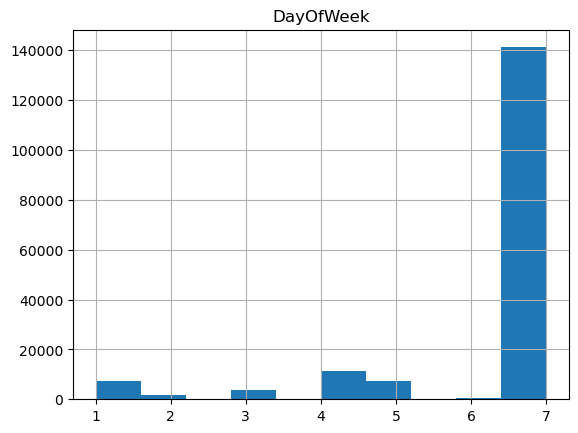

In [373]:
# Plotting the distribution of days when the stores were closed
closed_stores_data.hist('DayOfWeek')

<Axes: xlabel='SchoolHoliday'>

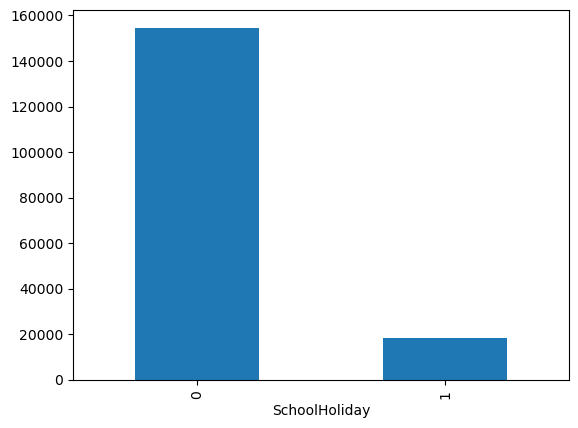

In [374]:
# Plotting the distribution of school holidays when the stores were closed
closed_stores_data['SchoolHoliday'].value_counts().plot(kind='bar')

<Axes: xlabel='StateHoliday'>

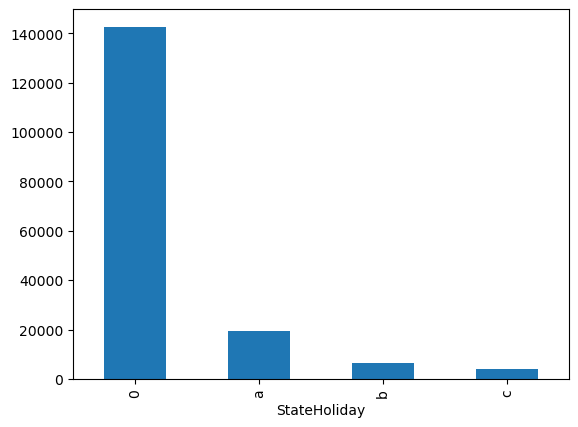

In [375]:
# Plotting the distribution of state holidays when the stores were closed
closed_stores_data['StateHoliday'].value_counts().plot(kind='bar')

In [376]:
# Counting the number of occurrences where the store was open (Open == 1) and had zero sales (Sales == 0)
num_zero_sales_while_open = train_data[(train_data.Open == 1) & (train_data.Sales == 0)].shape[0]
num_zero_sales_while_open

54

In [377]:
# Checking the count of missing values in the 'train_data' DataFrame
missing_values_count = train_data.isnull().sum()
missing_values_count

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [378]:
# Checking the count of missing values in the 'store_data' DataFrame
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [379]:
# Checking the count of missing values in the 'test_data' DataFrame
test_data.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [380]:
# Filtering rows in 'store_data' where 'CompetitionDistance' is null
missing_competition_distance_data = store_data[store_data['CompetitionDistance'].isnull()]
missing_competition_distance_data

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [381]:
# Filtering rows in 'store_data' where 'Promo2SinceWeek' is null
store_data[store_data['Promo2SinceWeek'].isnull()][:5]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   
5      6         a          a                310.0                       12.0   
6      7         a          c              24000.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   
5                    2013.0       0              NaN              NaN   
6                    2013.0       0              NaN              NaN   

  PromoInterval  
0           NaN  
3           NaN  
4           NaN  
5           NaN  
6           NaN

## Feature Engineering of Store Data

In [382]:
# Filling missing values in the 'CompetitionDistance' column with the median value
store_data["CompetitionDistance"].fillna(value = store_data.CompetitionDistance.median(), inplace=True)

In [383]:
# Filling missing values in 'CompetitionOpenSinceMonth' with the mode value
store_data["CompetitionOpenSinceMonth"].fillna(value=store_data.CompetitionOpenSinceMonth.mode()[0], inplace=True)

# Filling missing values in 'CompetitionOpenSinceYear' with the mode value
store_data["CompetitionOpenSinceYear"].fillna(value=store_data.CompetitionOpenSinceYear.mode()[0], inplace=True)

In [384]:
# Filling missing values in 'Promo2SinceWeek' with the value 0
store_data["Promo2SinceWeek"].fillna(value=0, inplace=True)

# Filling missing values in 'Promo2SinceYear' with the value 0
store_data["Promo2SinceYear"].fillna(value=0, inplace=True)

# Filling missing values in 'PromoInterval' with the value 0
store_data["PromoInterval"].fillna(value=0, inplace=True)

## Feature Engineering of Test Data

In [385]:
# Filling missing values in 'test_data' with the value 1
test_data.fillna(value=1, inplace=True)

## Merge with Store

In [386]:
# Merging 'train_data' and 'store_data' on the 'Store' column
train_all = pd.merge(train_data, store_data, on='Store')

# Merging 'test_data' and 'store_data' on the 'Store' column
test_all = pd.merge(test_data, store_data, on='Store')

## Check & Remove the Outliers

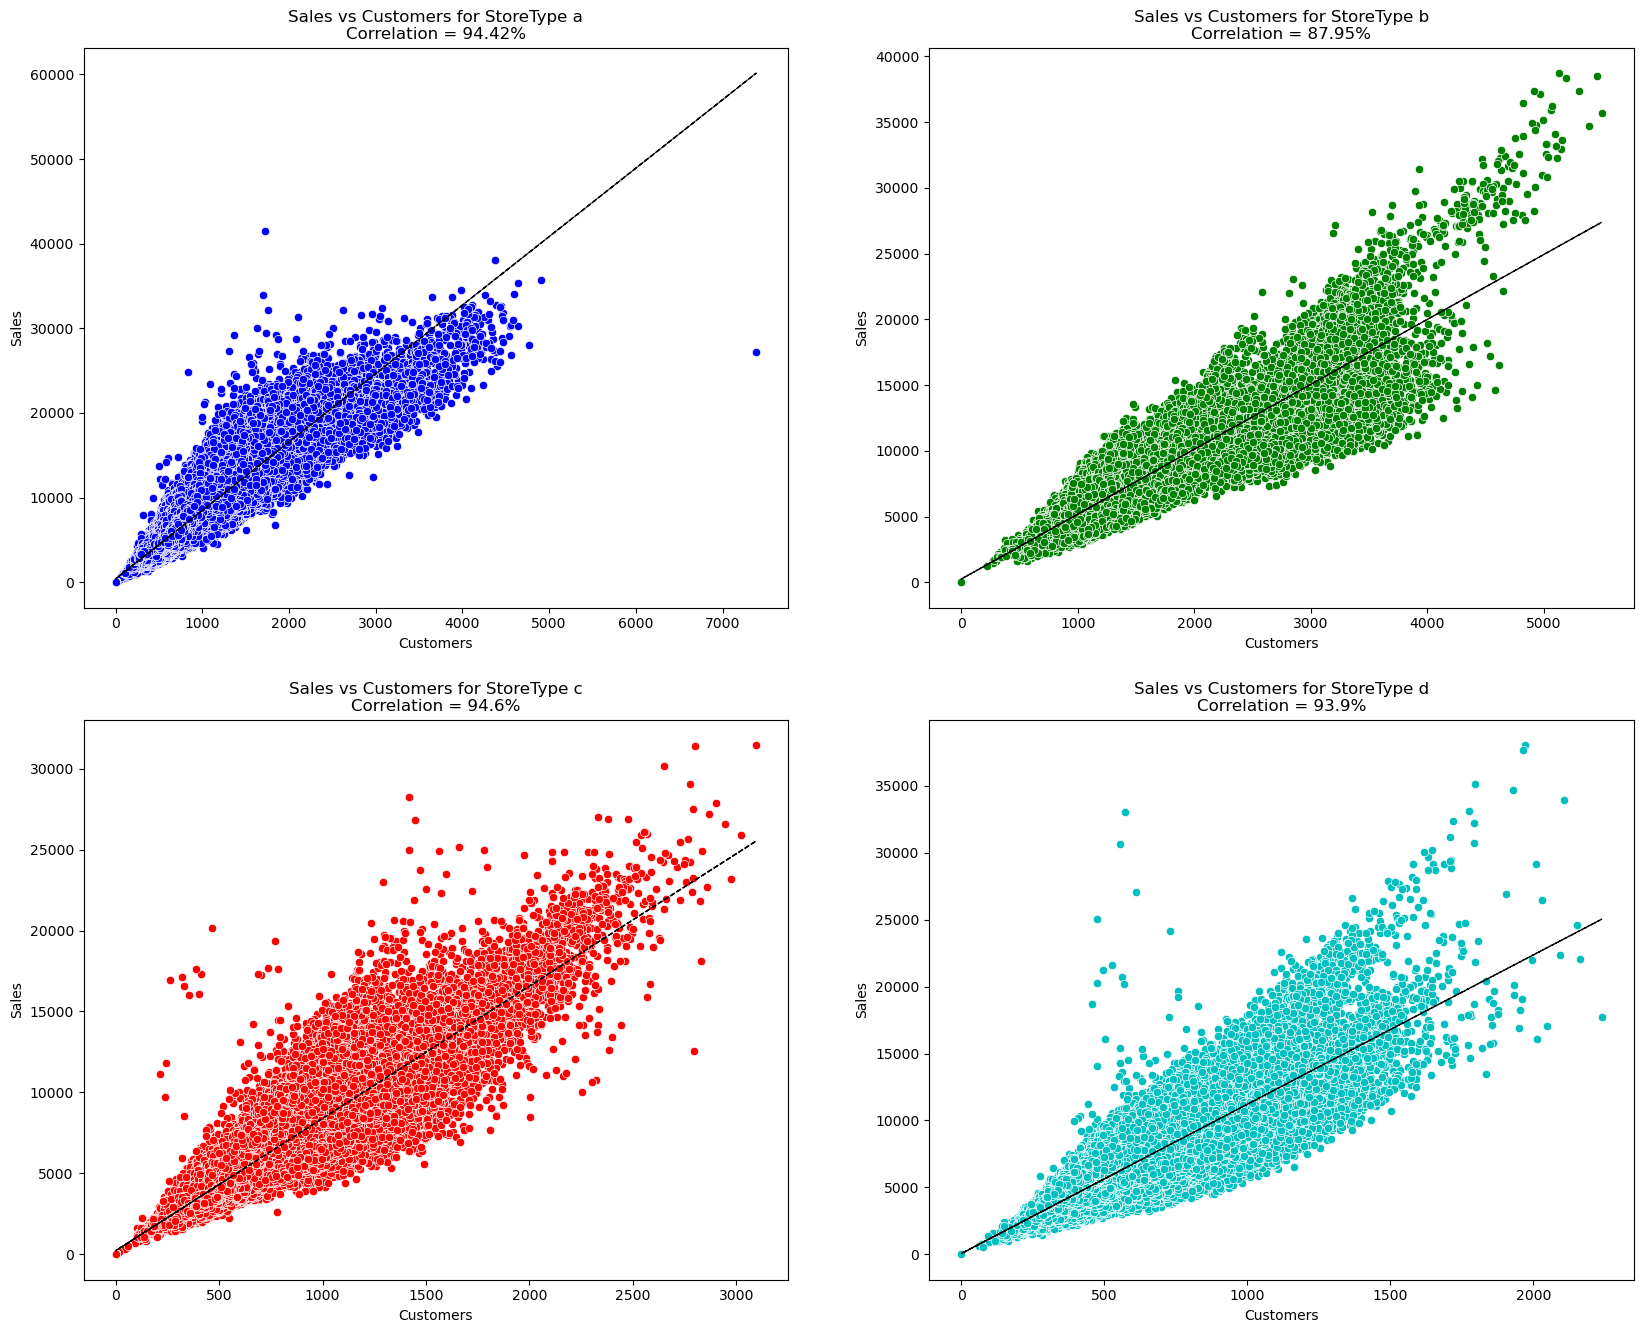

In [387]:
# Generate scatter plots to examine the relationship between 'Sales' and 'Customers' for each store type
plot_customers_vs_sales_by_feature(train_all, 'StoreType')

In [388]:
# Define a filter ('a_filter') for StoreType 'a' to remove outliers based on specific conditions related to 'Sales' and 'Customers'
a_filter = train_all[
    (train_all['StoreType'] == 'a') &
    (((train_all['Sales'] > 20000) & (train_all['Customers'] < 1000)) |
     (train_all['Sales'] > 40000) | (train_all['Customers'] > 7000))
].index

# Define a filter ('c_filter') for StoreType 'c' to remove outliers based on specific conditions related to 'Sales' and 'Customers'
c_filter = train_all[
    (train_all['StoreType'] == 'c') &
    (((train_all['Sales'] > 9000) & (train_all['Customers'] < 500)) |
     ((train_all['Sales'] < 15000) & (train_all['Customers'] > 2500)) |
     ((train_all['Sales'] > 25000) & (train_all['Customers'] < 2000)) |
     (train_all['Sales'] > 30000))
].index

# Define a filter ('d_filter') for StoreType 'd' to remove outliers based on specific conditions related to 'Sales' and 'Customers'
d_filter = train_all[
    (train_all['StoreType'] == 'd') &
    ((train_all['Sales'] > 17500) & (train_all['Customers'] < 875) |
     (train_all['Sales'] > 31000) | (train_all['Customers'] > 2000))
].index


In [389]:
print(a_filter.shape,c_filter.shape,d_filter.shape)

(3,) (18,) (32,)


In [390]:
# Remove outliers from 'train_all' DataFrame using the defined filters
train_all.drop(a_filter, inplace=True)
train_all.drop(c_filter, inplace=True)
train_all.drop(d_filter, inplace=True)

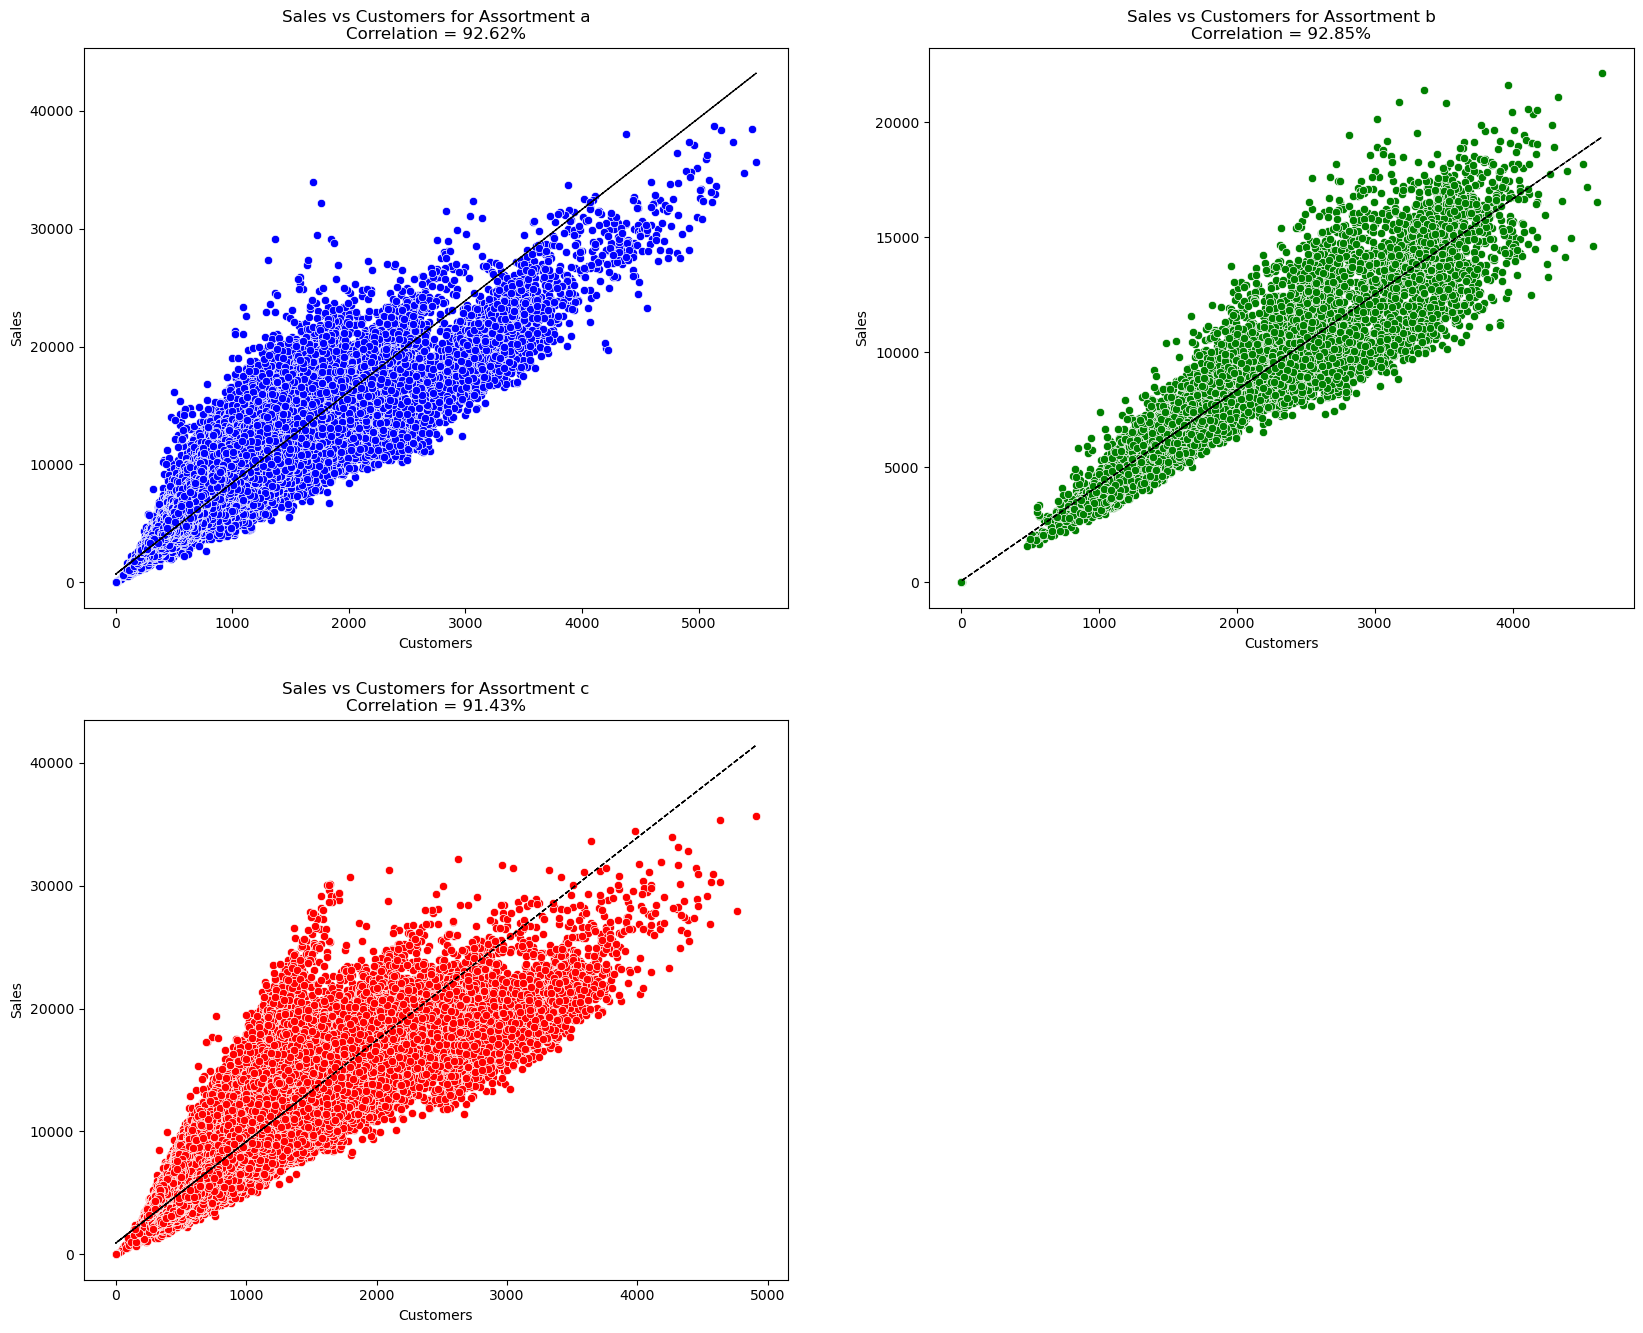

In [391]:
# Generate scatter plots to examine the relationship between 'Sales' and 'Customers' for each assortment type
plot_customers_vs_sales_by_feature(train_all, 'Assortment')

In [392]:
# Define a filter ('a_filter_assortment') for Assortment 'a' to remove outliers based on specific conditions related to 'Sales' and 'Customers'
a_filter_assortment = train_all[
    (train_all['Assortment'] == 'a') &
    (((train_all['Sales'] > 20000) & (train_all['Customers'] < 1000)) |
     ((train_all['Sales'] > 27500) & (train_all['Customers'] < 2000)) |
     ((train_all['Sales'] > 31000) & (train_all['Customers'] < 3250)) |
     (train_all['Sales'] > 35000))
].index

In [393]:
# Remove outliers from 'train_all' DataFrame using the defined filter ('a_filter_assortment')
train_all.drop(a_filter_assortment, inplace=True)

##Feature Engineering on Train and Test Data

In [394]:
# Sort the 'train_all' DataFrame by 'Date' in descending order
train = train_all.sort_values(['Date'], ascending=False)
train.shape

(1017135, 18)

In [395]:
# train[train['Open'] == 0]

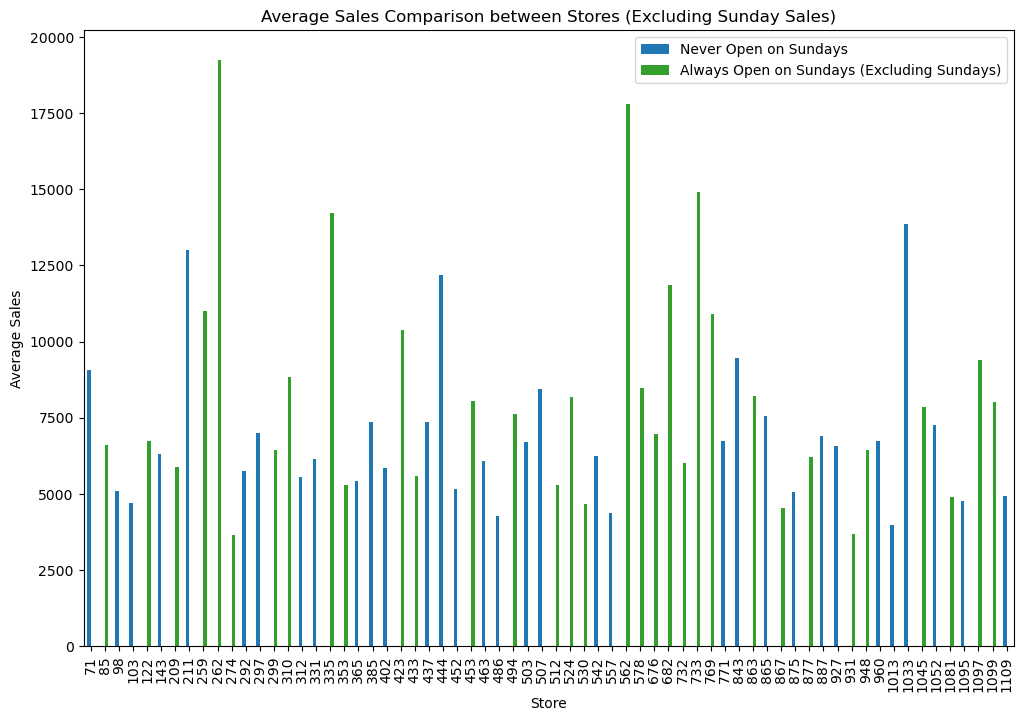

In [396]:
# Identify stores that never open on Sundays
closed_sundays_stores = train[(train['DayOfWeek'] == 7) & (train['Open'] == 0)]['Store'].unique()
never_open_on_sundays = train[(train['Store'].isin(closed_sundays_stores)) & (train['DayOfWeek'] != 7)]
# never_open_on_sundays

# # Check if there are non-zero sales for stores that never open on Sundays
non_zero_sales_never_open_on_sundays = never_open_on_sundays[never_open_on_sundays['Sales'] > 0]


# # Identify stores that always open on Sundays
# # Exclude Sunday sales for stores that always open on Sundays
open_sundays_stores = train[(train['DayOfWeek'] == 7) & (train['Open'] == 1)]['Store'].unique()
always_open_on_sundays_excluding_sunday =  train[(train['Store'].isin(open_sundays_stores)) & (train['DayOfWeek'] != 7)]

# Calculate average sales for each group
average_sales_never_open_on_sundays = non_zero_sales_never_open_on_sundays.groupby('Store')['Sales'].mean()
average_sales_always_open_on_sundays = always_open_on_sundays_excluding_sunday.groupby('Store')['Sales'].mean()
average_sales_never_open_on_sundays = average_sales_never_open_on_sundays.sample(n=33, random_state=42)

# Create a DataFrame for plotting
comparison_data = pd.DataFrame({
    'Never Open on Sundays': average_sales_never_open_on_sundays,
    'Always Open on Sundays (Excluding Sundays)': average_sales_always_open_on_sundays
})

# Plotting
comparison_data.plot(kind='bar', figsize=(12, 8), color=['#1f78b4', '#33a02c'])
plt.title('Average Sales Comparison between Stores (Excluding Sunday Sales)')
plt.xlabel('Store')
plt.ylabel('Average Sales')

plt.show()


In [397]:
# Filter rows in the 'train' DataFrame where 'Open' is not equal to 0
train = train[train["Open"] != 0]

# Filter rows in the 'train' DataFrame where 'Sales' is greater than 0
train = train[train["Sales"] > 0]

In [398]:
get_datetime_info(train)
get_datetime_info(test_all)

mark_promo_months(train)
mark_promo_months(test_all)

calculate_promo_open_duration(train)
calculate_promo_open_duration(test_all)

calculate_competition_open_duration(train)
calculate_competition_open_duration(test_all)

encode_categorical_features(train)
encode_categorical_features(test_all)

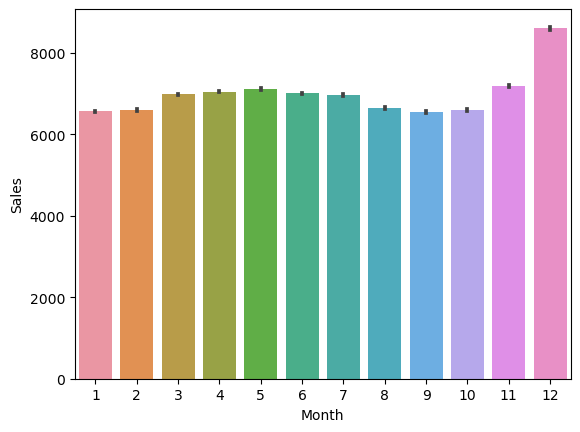

In [399]:
#barplot month Vs sales
sns.barplot(x = 'Month', y = 'Sales', data = train)
plt.show()

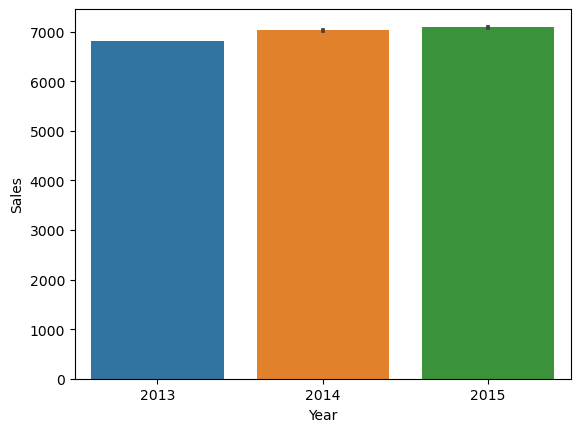

In [400]:
#barplot year Vs sales
sns.barplot(x = 'Year', y = 'Sales', data = train)
plt.show()

In [401]:
# national_holiday_ratio = train['NationalHoliday'].value_counts(normalize=True) * 100
# national_holiday_ratio

The figure layout has changed to tight


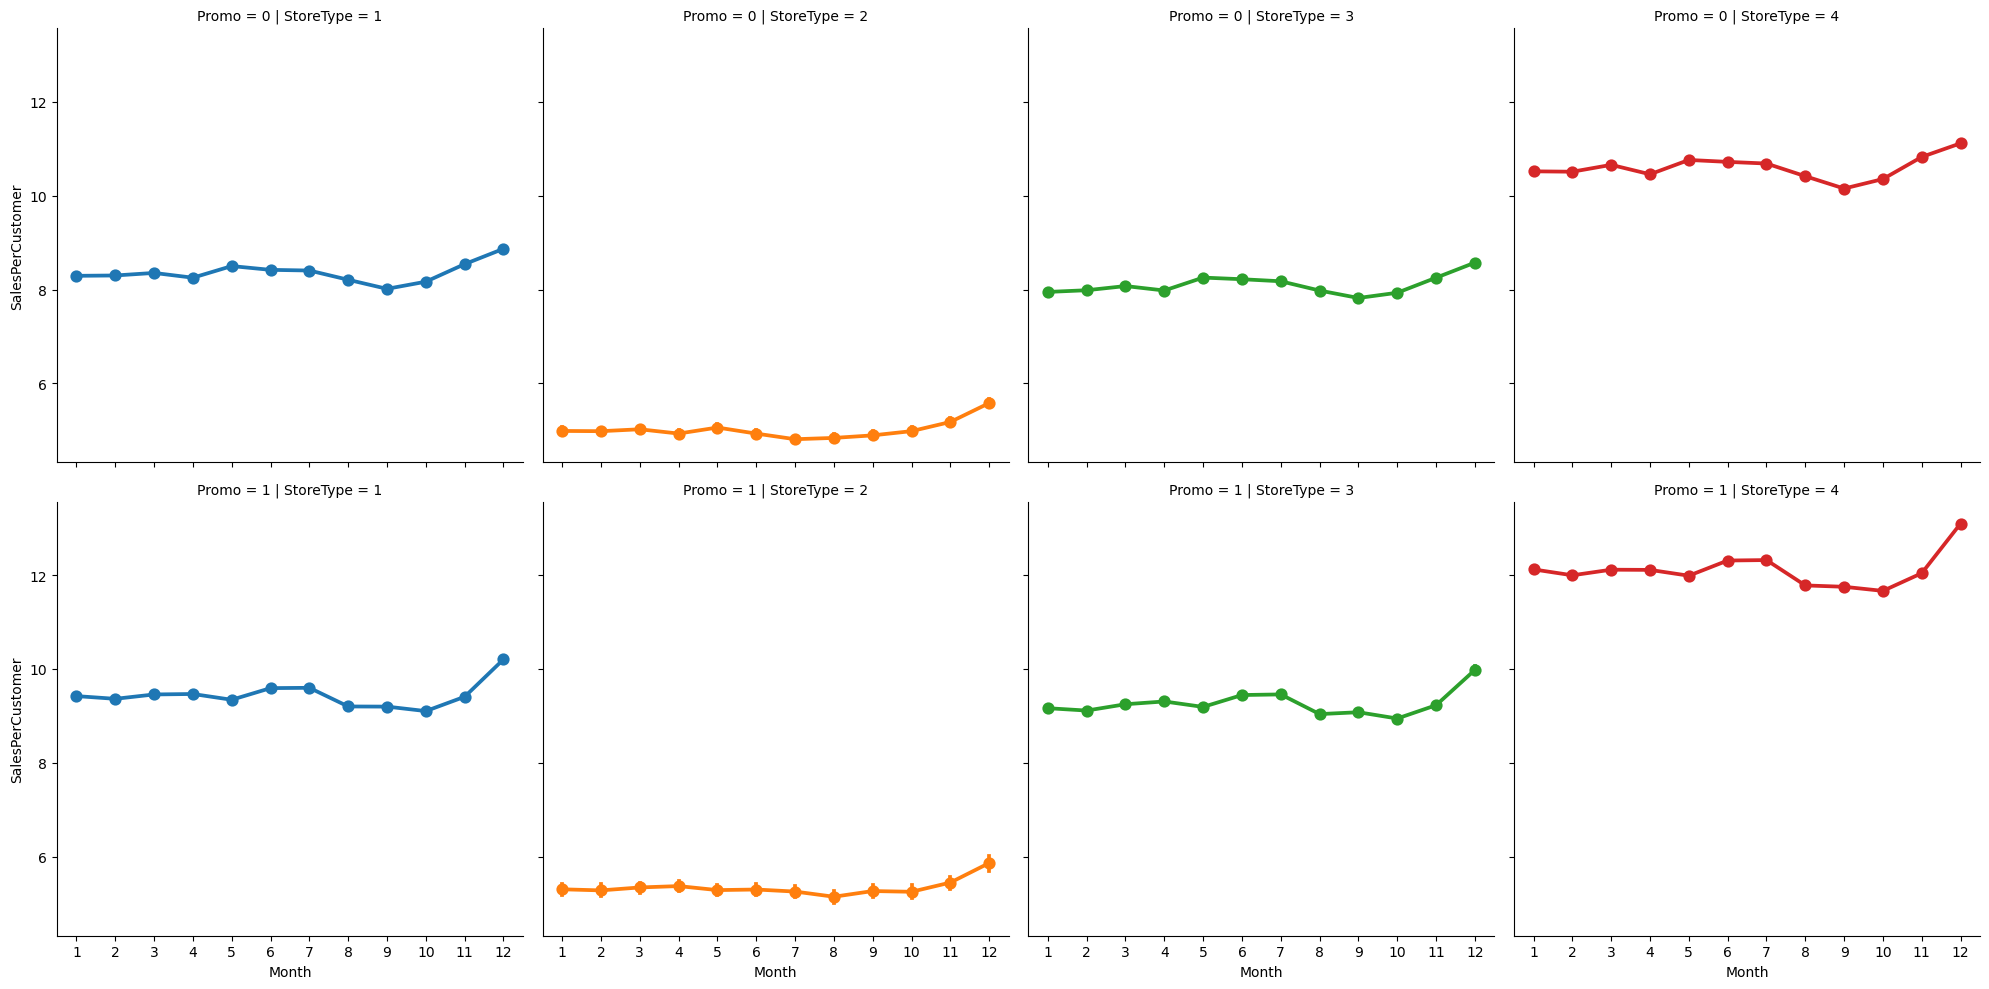

In [402]:
# Calculate 'SalesPerCustomer' by dividing 'Sales' by 'Customers'
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

# Sales trend over the months using seaborn catplot
sns.catplot(data=train, x="Month", y="SalesPerCustomer",
            col='StoreType',  # per store type in columns
            hue='StoreType',
            row="Promo",
            kind="point"
           )

# Display the plot
plt.show()

The figure layout has changed to tight


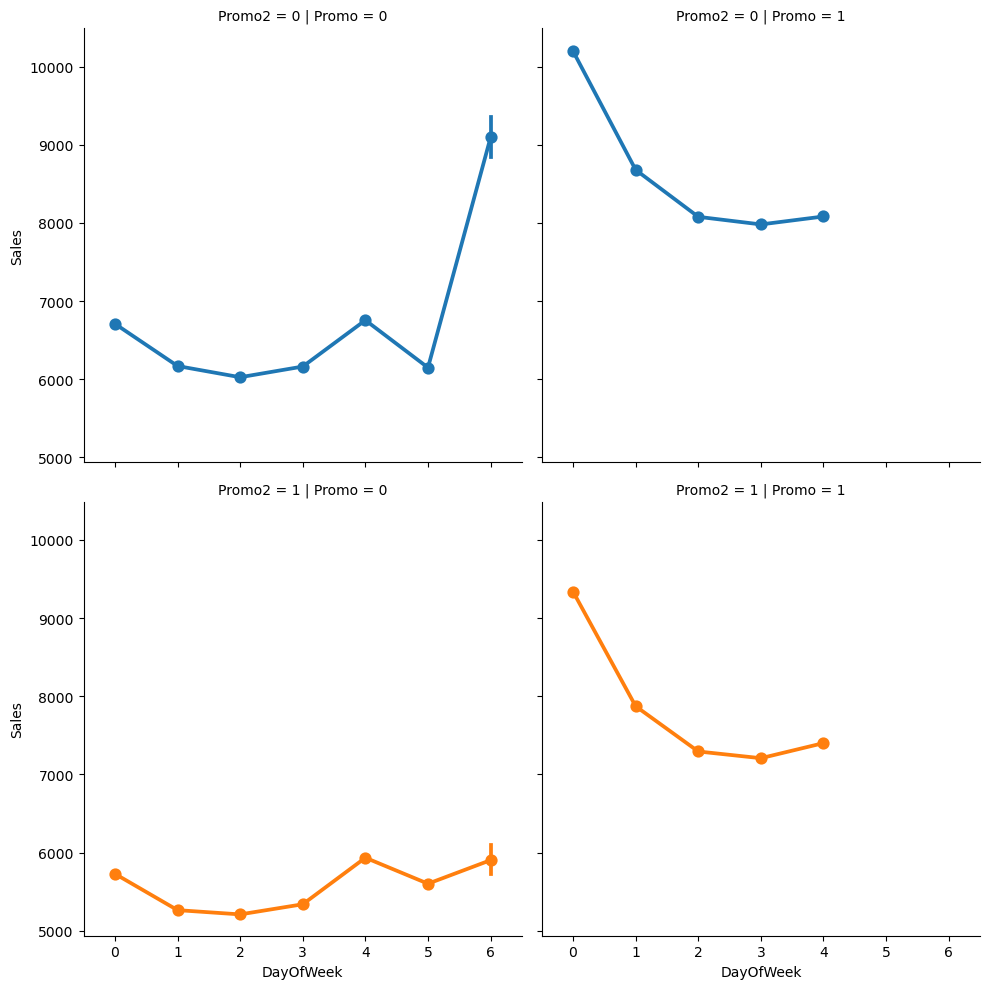

In [403]:
# Sales trend over the months
sns.catplot(data = train, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               kind="point"
           ) 

plt.show()

In [404]:
# train['IsPromoMonth']

In [405]:
train_trend_analysis = train.copy()
train_trend_analysis.set_index('Date', inplace=True)

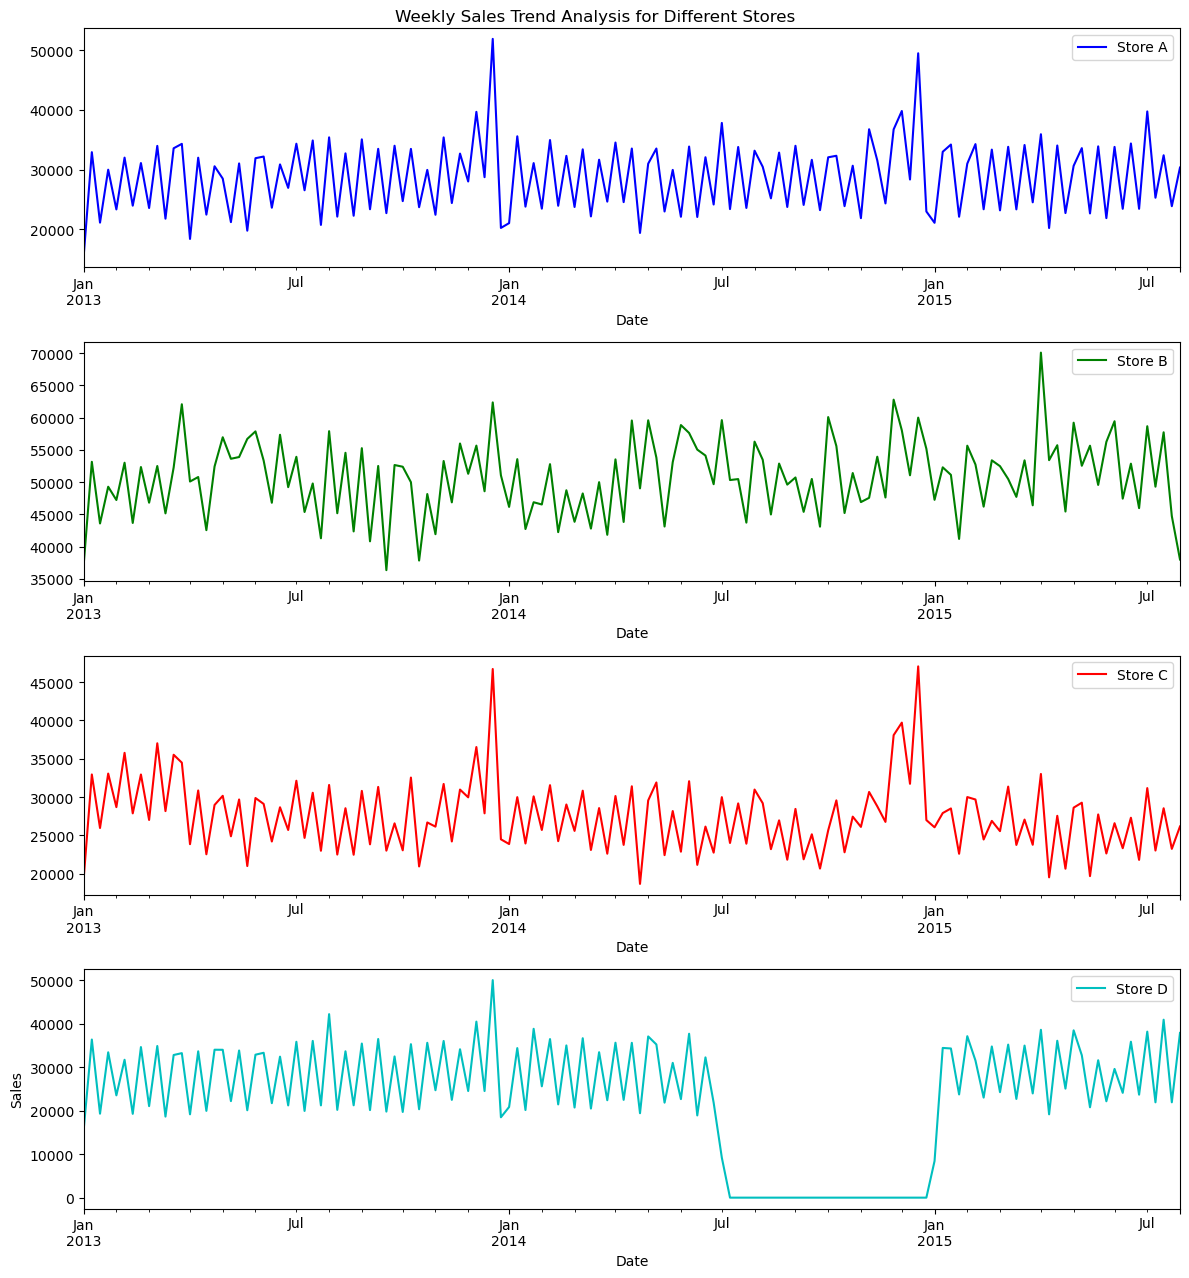

In [406]:
# Assigning one store from each category
sales_a = train_trend_analysis[train_trend_analysis.Store == 2]['Sales']
sales_b = train_trend_analysis[train_trend_analysis.Store == 85]['Sales'].sort_index(ascending=True)
sales_c = train_trend_analysis[train_trend_analysis.Store == 1]['Sales']
sales_d = train_trend_analysis[train_trend_analysis.Store == 13]['Sales']

# Set color palette for better distinction
colors = ['b', 'g', 'r', 'c']

# Create subplots
fig, axes = plt.subplots(4, figsize=(12, 13))

# Trend Analysis
sales_a.resample('W').sum().plot(ax=axes[0], color=colors[0], label='Store A')
sales_b.resample('W').sum().plot(ax=axes[1], color=colors[1], label='Store B')
sales_c.resample('W').sum().plot(ax=axes[2], color=colors[2], label='Store C')
sales_d.resample('W').sum().plot(ax=axes[3], color=colors[3], label='Store D')

# Set common labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.suptitle('Weekly Sales Trend Analysis for Different Stores')

# Add legends
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Analysis

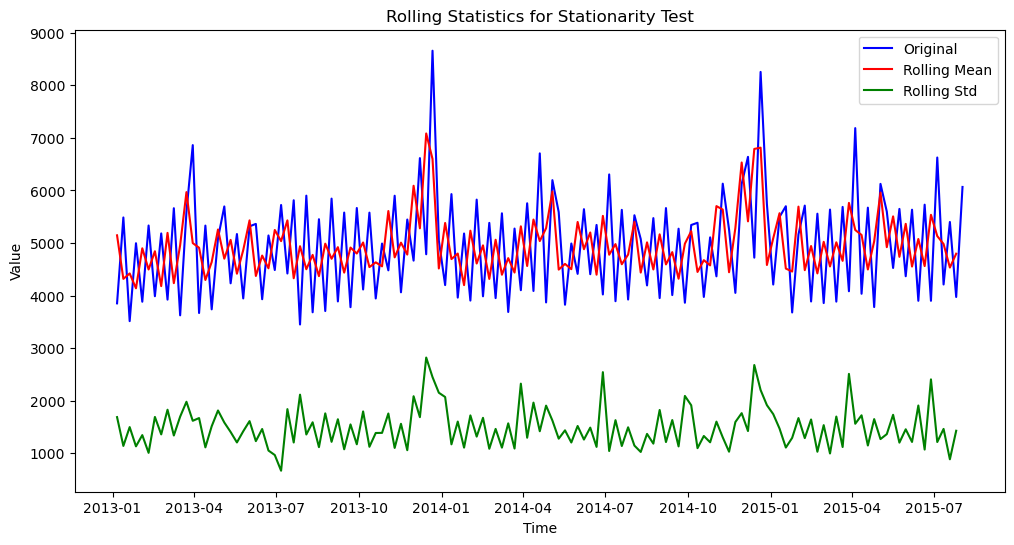

Results of Dickey-Fuller Test:
ADF Statistic: -5.292708
p-value: 0.000006
Critical Values:
1% -3.438915730045254
5% -2.8653205426302253
10% -2.5687831424305845


In [407]:
# Testing stationarity of sales data for Store Type A
analyze_stationarity(sales_a)

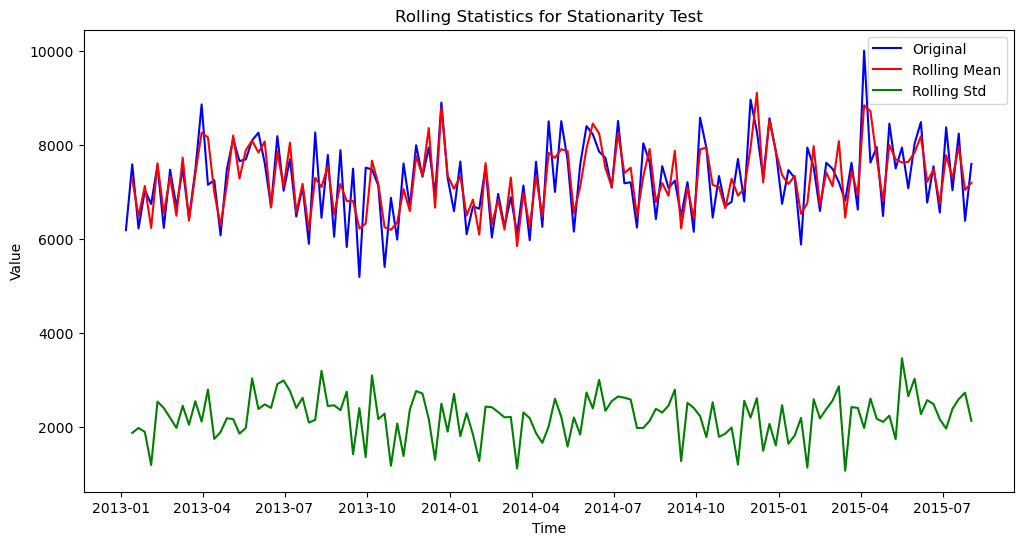

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [408]:
# Testing stationarity of sales data for Store Type B
analyze_stationarity(sales_b)

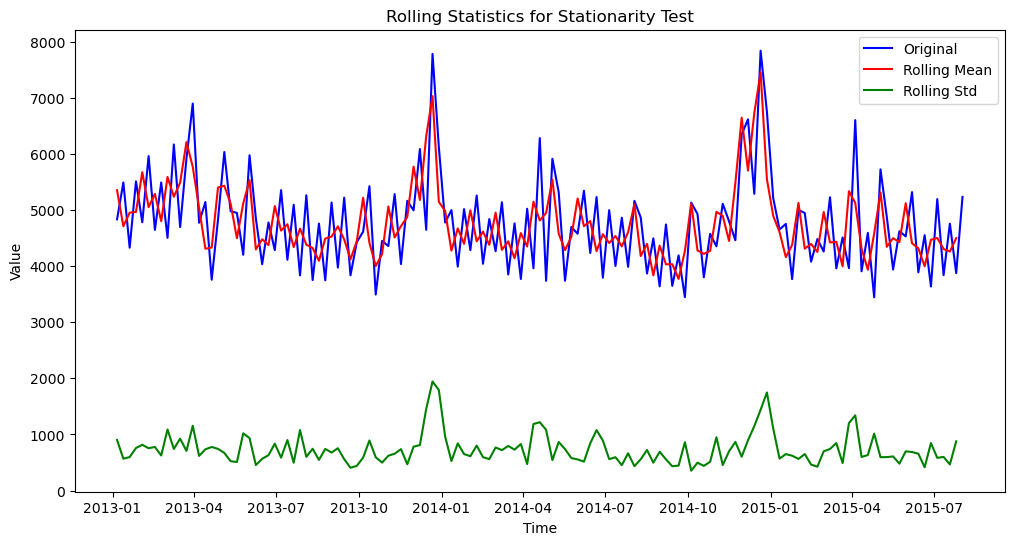

Results of Dickey-Fuller Test:
ADF Statistic: -5.412786
p-value: 0.000003
Critical Values:
1% -3.4389045244994096
5% -2.8653156040031176
10% -2.5687805115003


In [409]:
# Testing stationarity of sales data for Store Type C
analyze_stationarity(sales_c)

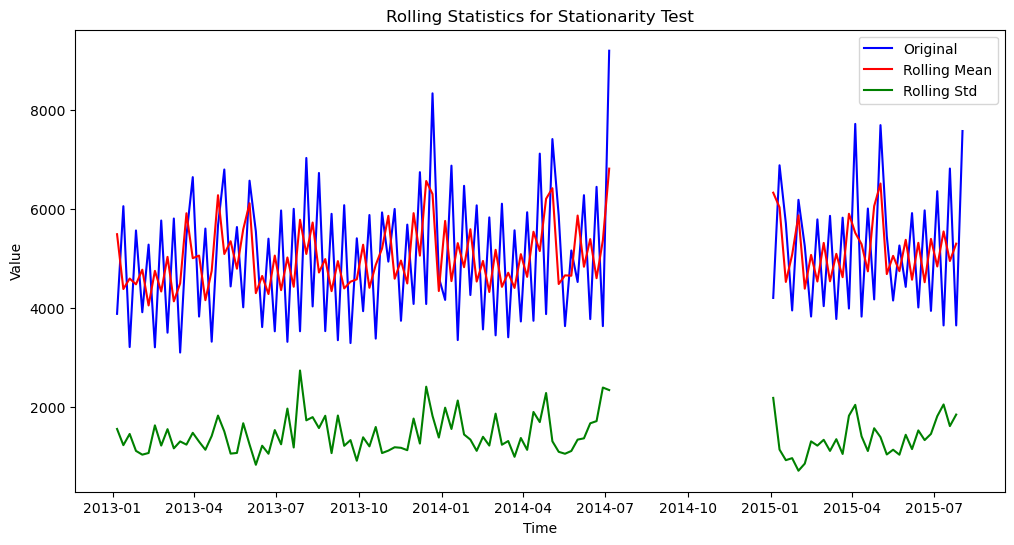

Results of Dickey-Fuller Test:
ADF Statistic: -6.321001
p-value: 0.000000
Critical Values:
1% -3.4411511898545206
5% -2.866305414688104
10% -2.569307861950312


In [410]:
# Testing stationarity of sales data for Store Type D
analyze_stationarity(sales_d)

## Seasonality

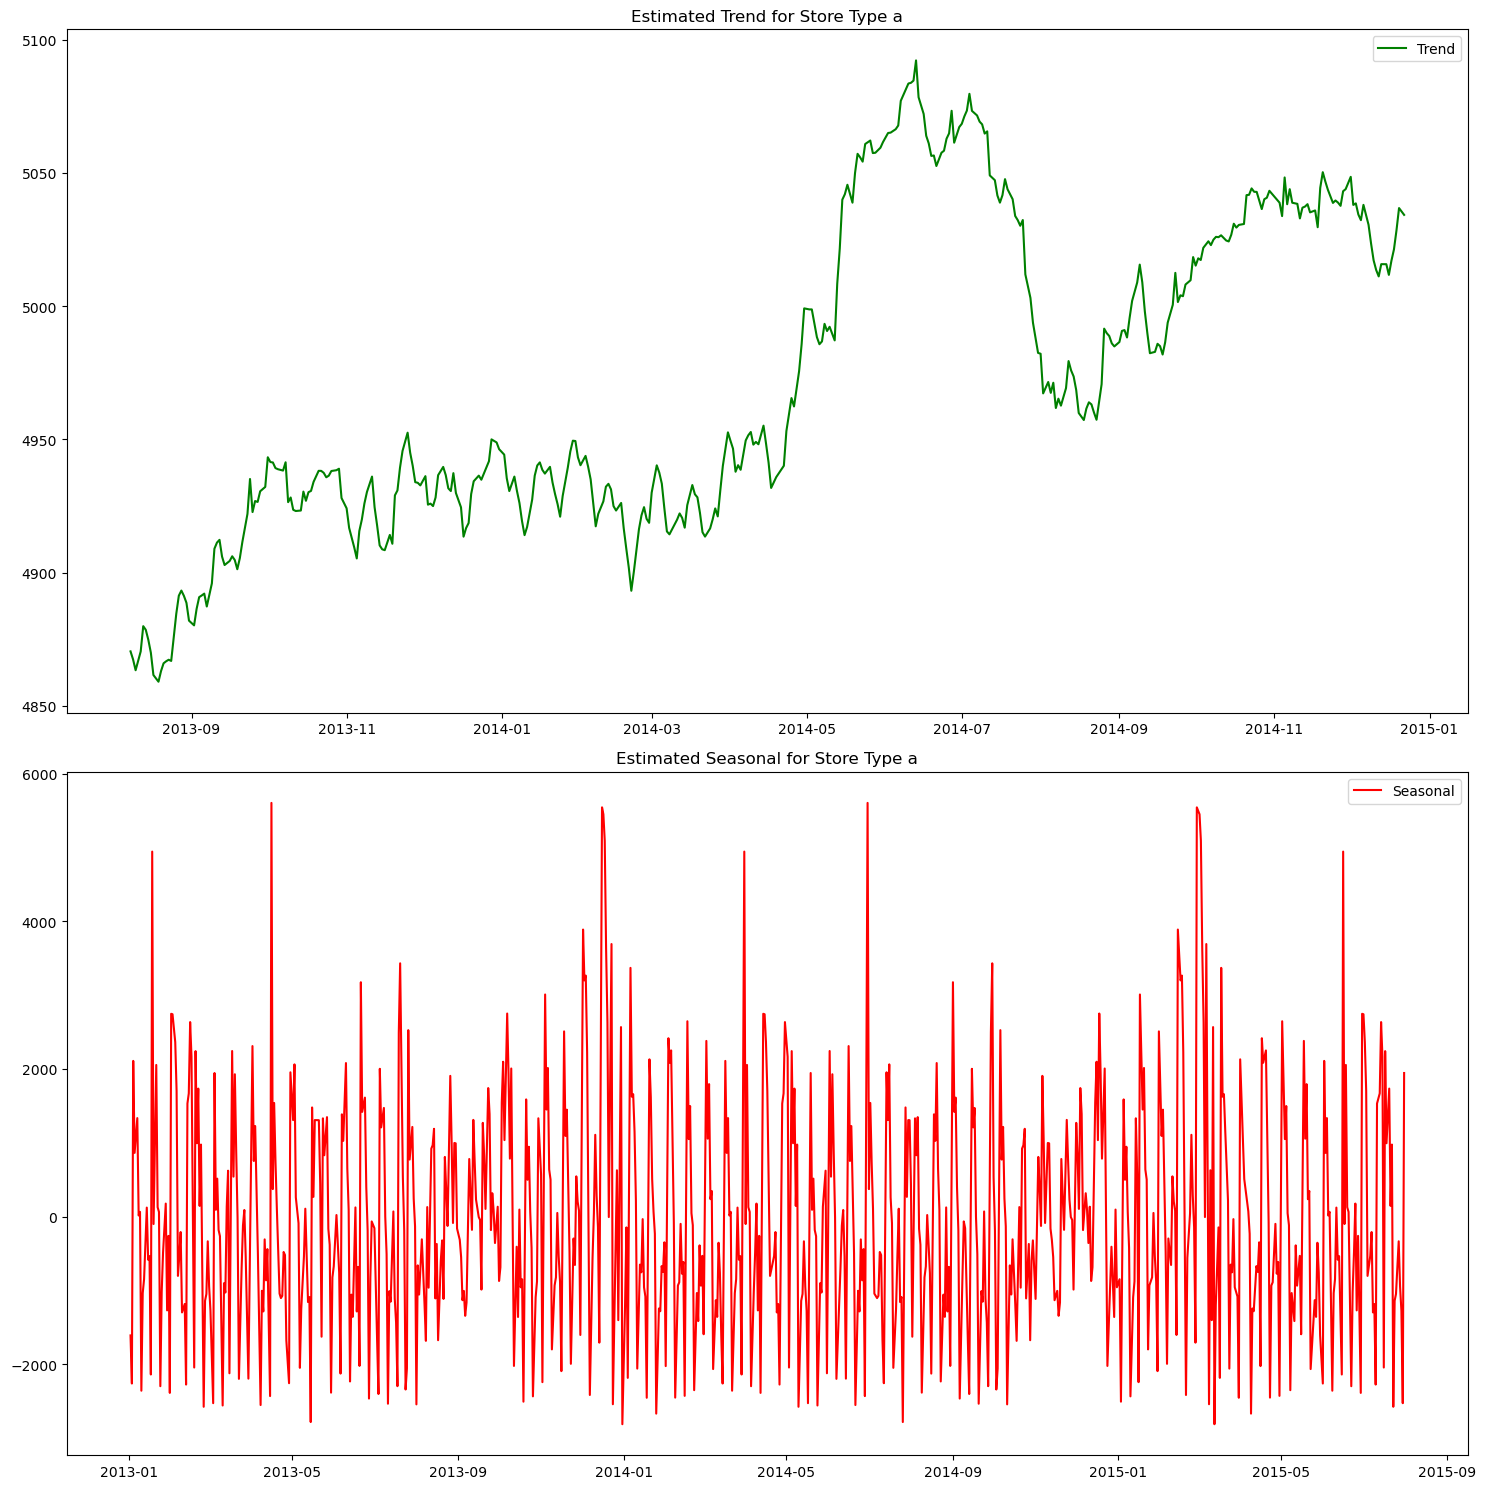

In [411]:
# Plotting seasonality and trend for sales data of Store Type A
visualize_seasonal_decomposition(sales_a, 'a', 365)

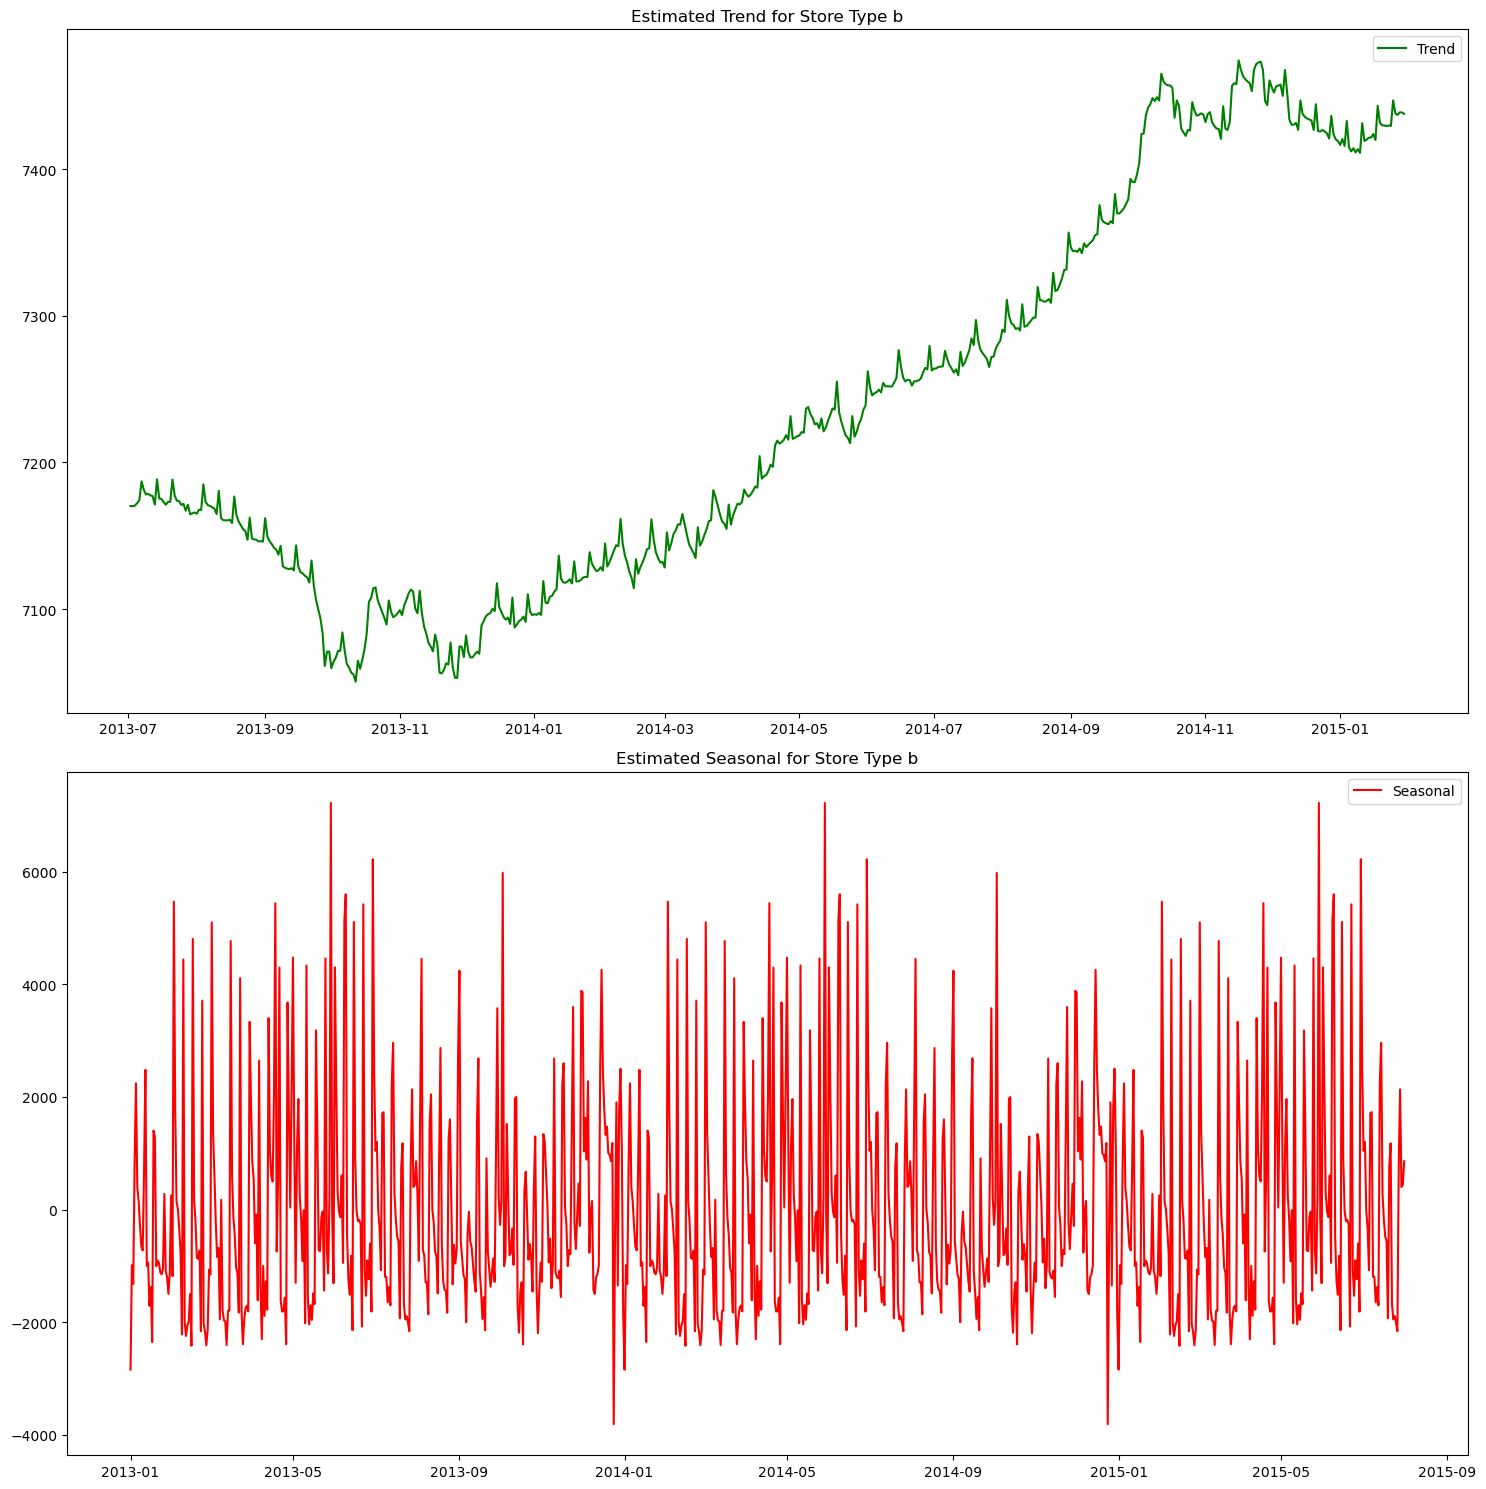

In [412]:
# Plotting seasonality and trend for sales data of Store Type B
visualize_seasonal_decomposition(sales_b, 'b', 365)

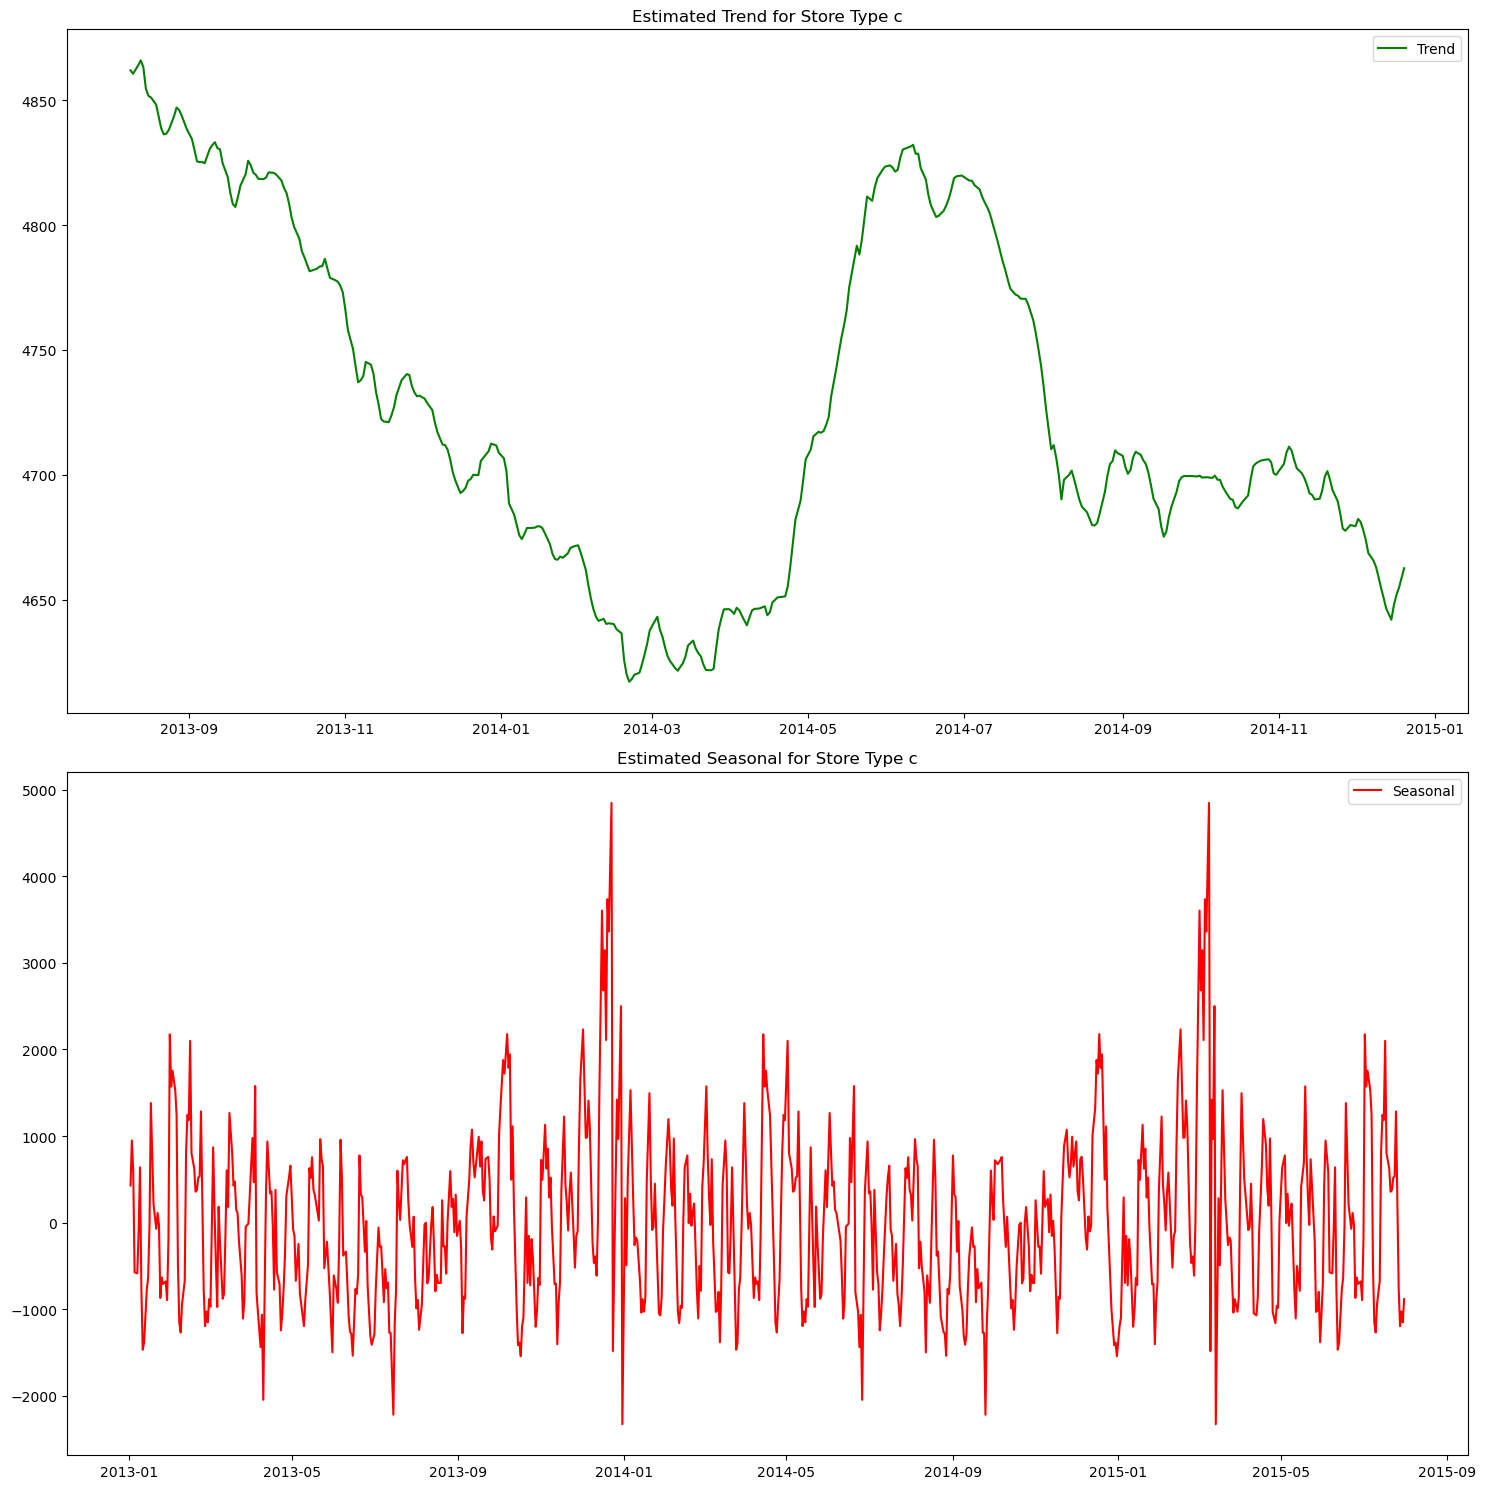

In [413]:
# Plotting seasonality and trend for sales data of Store Type C
visualize_seasonal_decomposition(sales_c, 'c', 365)

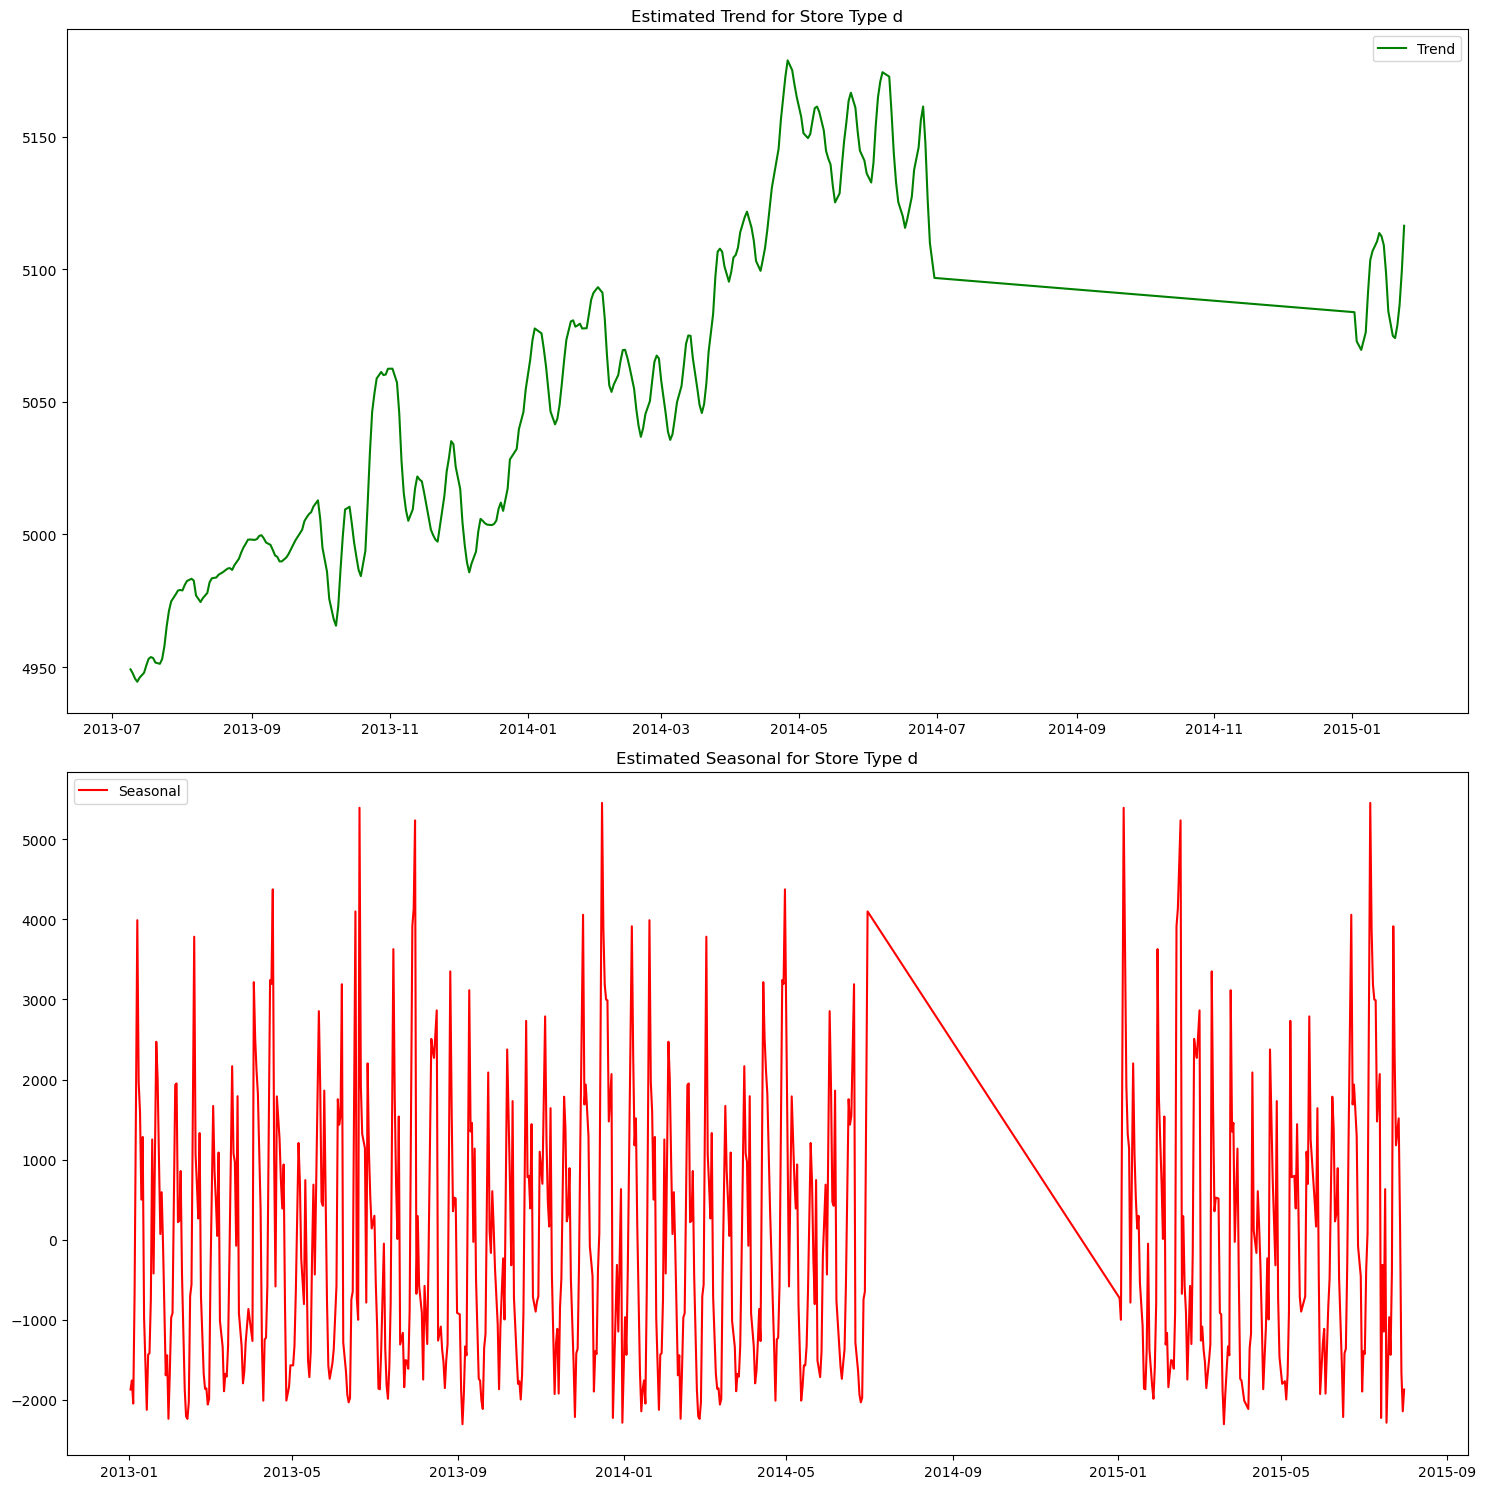

In [414]:
# Plotting seasonality and trend for sales data of Store Type D
visualize_seasonal_decomposition(sales_d, 'd', 310)

## Autocorrelation

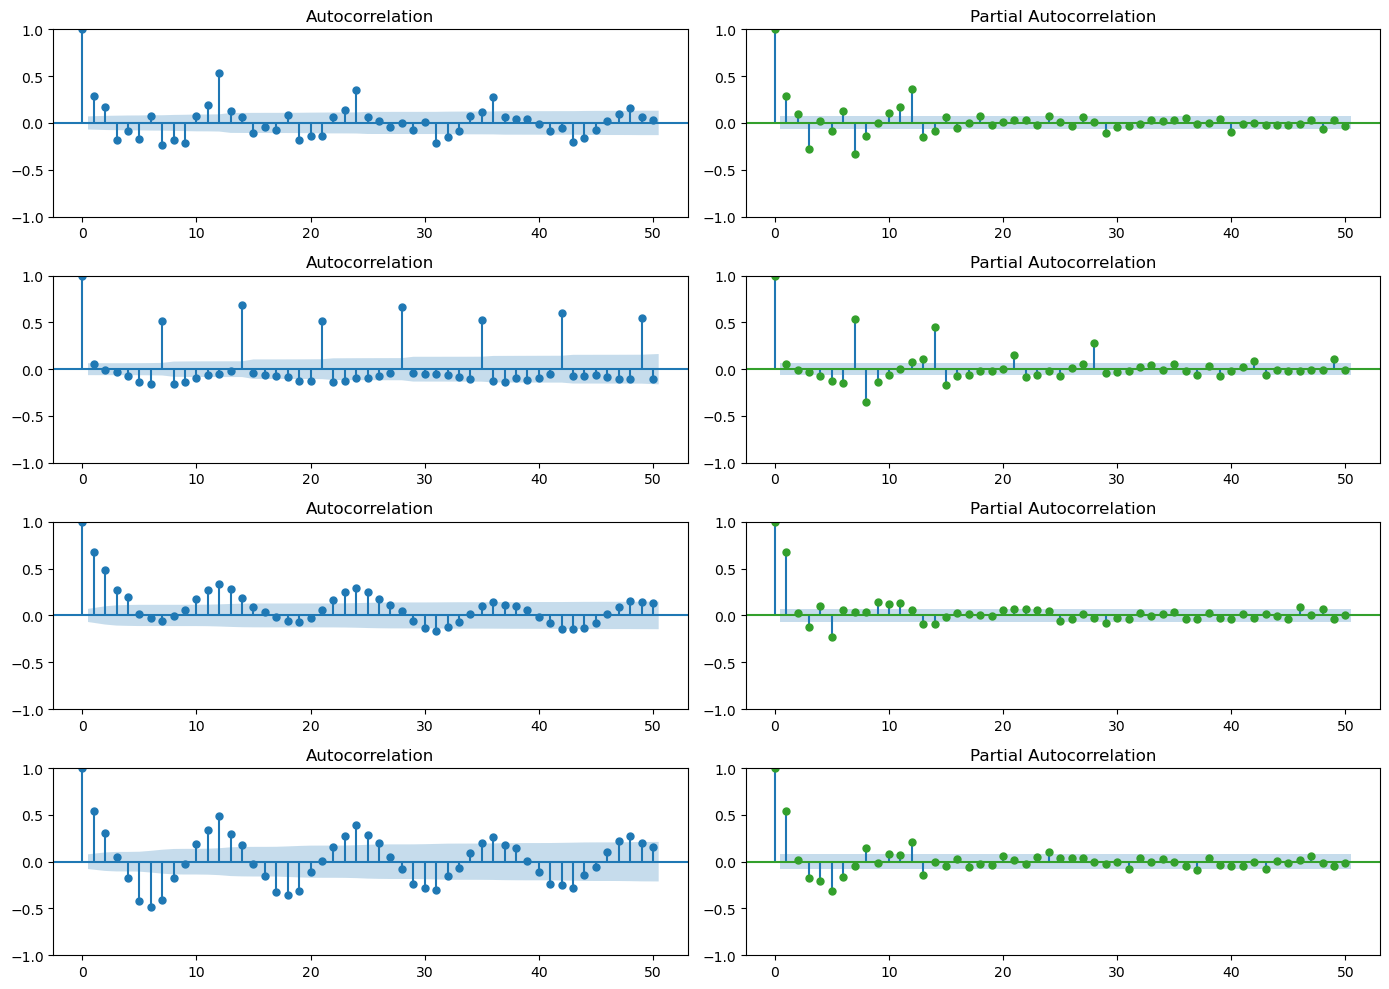

In [415]:
# Figure for subplots
plt.figure(figsize=(14, 10))

# Colors for the plots
acf_color = '#1f78b4'  # Blue
pacf_color = '#33a02c'  # Green

# ACF and PACF for A
plt.subplot(421)
plot_acf(sales_a, lags=50, ax=plt.gca(), color=acf_color)
plt.subplot(422)
plot_pacf(sales_a, lags=50, ax=plt.gca(), color=pacf_color)

# ACF and PACF for B
plt.subplot(423)
plot_acf(sales_b, lags=50, ax=plt.gca(), color=acf_color)
plt.subplot(424)
plot_pacf(sales_b, lags=50, ax=plt.gca(), color=pacf_color)

# ACF and PACF for C
plt.subplot(425)
plot_acf(sales_c, lags=50, ax=plt.gca(), color=acf_color)
plt.subplot(426)
plot_pacf(sales_c, lags=50, ax=plt.gca(), color=pacf_color)

# ACF and PACF for D
plt.subplot(427)
plot_acf(sales_d, lags=50, ax=plt.gca(), color=acf_color)
plt.subplot(428)
plot_pacf(sales_d, lags=50, ax=plt.gca(), color=pacf_color)

plt.tight_layout()
plt.show()

# Part B - Dropping Columns and Generate Training & Test Dataset

In [416]:
train.drop(['Date','monthStr','PromoInterval','Open','SalesPerCustomer','PromoOpen','Customers'],axis=1,inplace =True)
test_all.drop(['Date','monthStr','PromoInterval','Open','PromoOpen'],axis=1,inplace =True)

<Axes: >

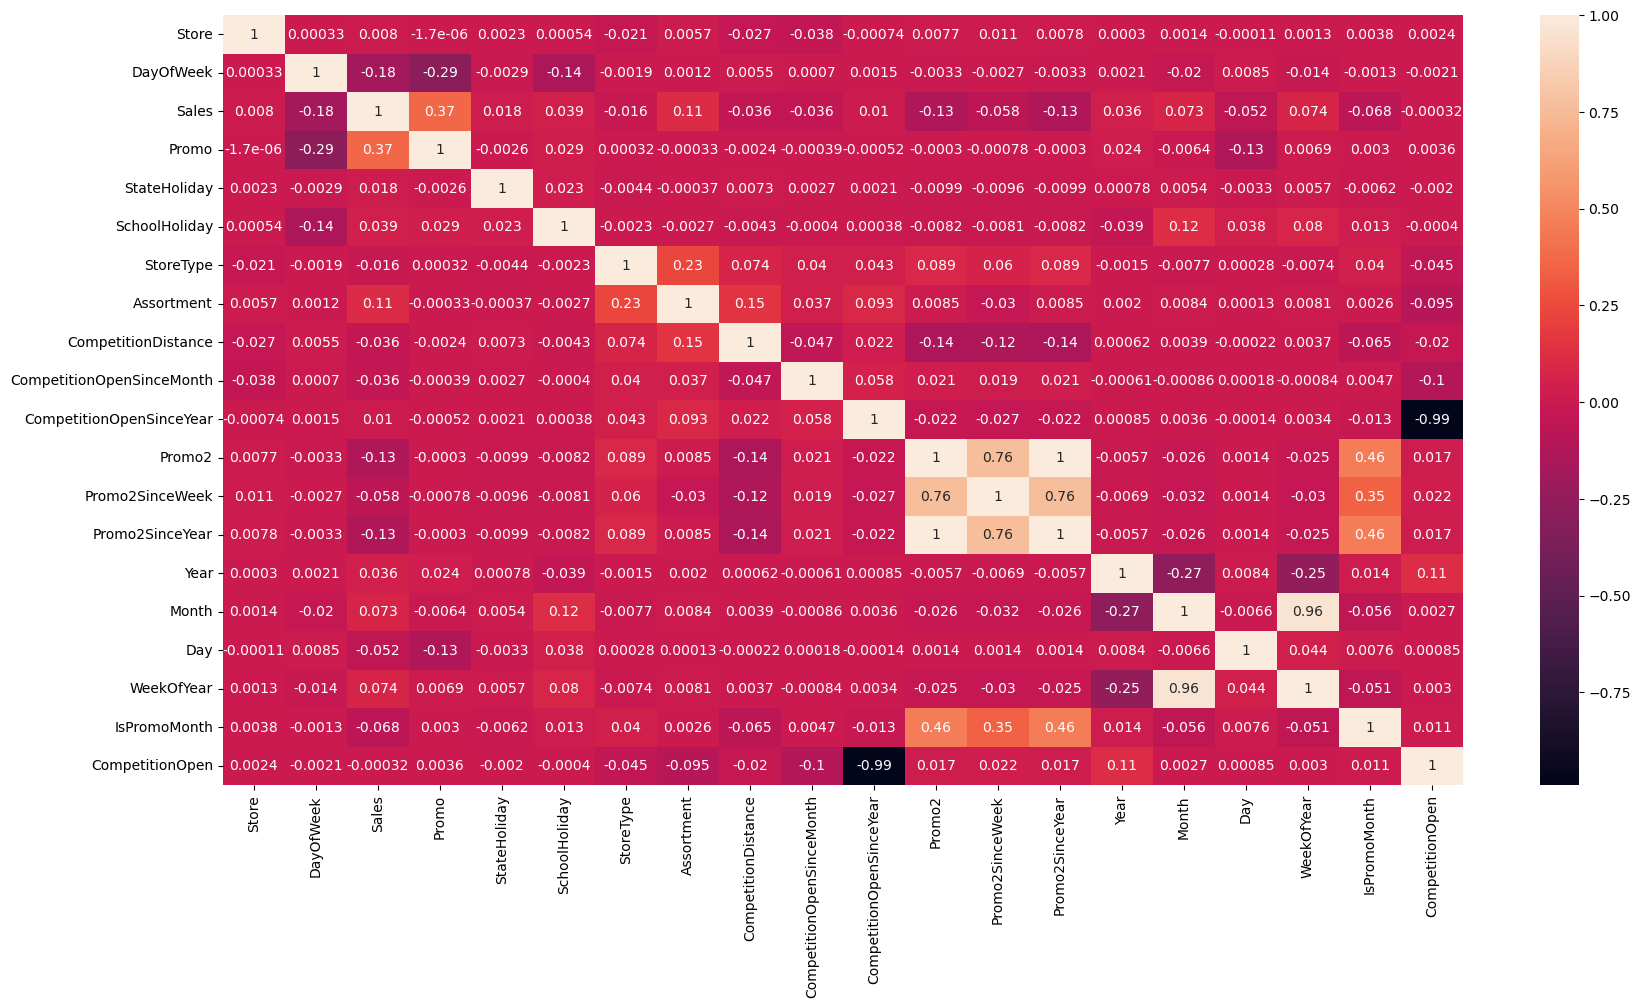

In [417]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(train.corr(), annot = True)

In [418]:
# Assuming 'train' is your DataFrame with the relevant data
correlation_matrix = train.corr()

# Filter the correlation for the 'Sales' variable
sales_correlation = correlation_matrix['Sales']

# Get the top 5 features with highest correlation (excluding 'Sales' itself)
top_features = sales_correlation.abs().sort_values(ascending=False).index

# Select only the relevant columns in the DataFrame
selected_features_df = train[top_features]

# # Plot the heatmap for the top 5 features
# plt.figure(figsize=(20, 10))
# sns.heatmap(selected_features_df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap for Other Features with Sales')
# plt.show()
selected_features_df.corr()

Sales     Promo  DayOfWeek  Promo2SinceYear  \
Sales                      1.000000  0.368827  -0.178910        -0.127727   
Promo                      0.368827  1.000000  -0.289268        -0.000301   
DayOfWeek                 -0.178910 -0.289268   1.000000        -0.003255   
Promo2SinceYear           -0.127727 -0.000301  -0.003255         1.000000   
Promo2                    -0.127703 -0.000299  -0.003257         0.999999   
Assortment                 0.109360 -0.000331   0.001225         0.008523   
WeekOfYear                 0.074271  0.006945  -0.014357        -0.024747   
Month                      0.073418 -0.006416  -0.019682        -0.025815   
IsPromoMonth              -0.068031  0.002961  -0.001295         0.456971   
Promo2SinceWeek           -0.058471 -0.000784  -0.002733         0.759358   
Day                       -0.052056 -0.126447   0.008524         0.001359   
SchoolHoliday              0.038613  0.028977  -0.139307        -0.008249   
Year                       0.036388  0.024000   0.002083        -0.005676   
CompetitionOpenSinceMonth -0.036015 -0.000389   0.000697         0.020940   
CompetitionDistance       -0.035805 -0.002383   0.005534        -0.141405   
StateHoliday               0.017589 -0.002584  -0.002861        -0.009918   
StoreType                 -0.016473  0.000316  -0.001947         0.089300   
CompetitionOpenSinceYear   0.010406 -0.000524   0.001457        -0.022022   
Store                      0.007951 -0.000002   0.000333         0.007751   
CompetitionOpen           -0.000316  0.003590  -0.002131         0.017125   

                             Promo2  Assortment  WeekOfYear     Month  \
Sales                     -0.127703    0.109360    0.074271  0.073418   
Promo                     -0.000299   -0.000331    0.006945 -0.006416   
DayOfWeek                 -0.003257    0.001225   -0.014357 -0.019682   
Promo2SinceYear            0.999999    0.008523   -0.024747 -0.025815   
Promo2                     1.000000    0.008476   -0.024742 -0.025810   
Assortment                 0.008476    1.000000    0.008079  0.008354   
WeekOfYear                -0.024742    0.008079    1.000000  0.960994   
Month                     -0.025810    0.008354    0.960994  1.000000   
IsPromoMonth               0.456972    0.002569   -0.051272 -0.056109   
Promo2SinceWeek            0.759544   -0.030120   -0.030408 -0.031713   
Day                        0.001359    0.000132    0.043678 -0.006593   
SchoolHoliday             -0.008246   -0.002712    0.079557  0.118448   
Year                      -0.005675    0.002047   -0.254400 -0.268804   
CompetitionOpenSinceMonth  0.020930    0.037175   -0.000845 -0.000865   
CompetitionDistance       -0.141342    0.150118    0.003704  0.003894   
StateHoliday              -0.009923   -0.000370    0.005748  0.005395   
StoreType                  0.089357    0.230835   -0.007373 -0.007698   
CompetitionOpenSinceYear  -0.022002    0.093013    0.003434  0.003574   
Store                      0.007719    0.005690    0.001324  0.001396   
CompetitionOpen            0.017107   -0.095449    0.003024  0.002728   

                           IsPromoMonth  Promo2SinceWeek       Day  \
Sales                         -0.068031        -0.058471 -0.052056   
Promo                          0.002961        -0.000784 -0.126447   
DayOfWeek                     -0.001295        -0.002733  0.008524   
Promo2SinceYear                0.456971         0.759358  0.001359   
Promo2                         0.456972         0.759544  0.001359   
Assortment                     0.002569        -0.030120  0.000132   
WeekOfYear                    -0.051272        -0.030408  0.043678   
Month                         -0.056109        -0.031713 -0.006593   
IsPromoMonth                   1.000000         0.346803  0.007642   
Promo2SinceWeek                0.346803         1.000000  0.001445   
Day                            0.007642         0.001445  1.000000   
SchoolHoliday                  0.01285

In [419]:
# Splitting the 'train' DataFrame into a holdout test set ('temp_test') and a holdout training set ('train_filtered')
test_filtered = train[:6 * 7 * 1115]  # The first 6 weeks of the data
train_filtered = train[6 * 7 * 1115:]  # The remaining data after the holdout test set

In [420]:
print(test_filtered['Month'])
print(test_filtered['Day'])

0          7
818868     7
444770     7
816984     7
57506      7
          ..
87904      6
108650     6
1014431    6
263292     6
70374      6
Name: Month, Length: 46830, dtype: int32
0          31
818868     31
444770     31
816984     31
57506      31
           ..
87904      13
108650     13
1014431    13
263292     13
70374      13
Name: Day, Length: 46830, dtype: int32


In [421]:
X_train = train_filtered.drop(['Sales'],axis=1 )
Y_train = np.log1p(train_filtered.Sales)
X_test = test_filtered.drop(['Sales'],axis=1 )
Y_test = np.log1p(test_filtered.Sales)

# Part C - Train XGBoost Model

In [422]:
train_matrix = xgb.DMatrix(X_train, Y_train)
valid_matrix = xgb.DMatrix(X_test, Y_test)
watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

In [423]:
params_opt = {
      "objective": "reg:squarederror",
      "booster" : "gbtree",
      "min_child_weight": 1,
      "eta": 0.03,
      "max_depth": 8,
      "subsample": 0.9,
      "colsample_bytree": 0.5,
      "seed": 42
  }

num_boost_round_opt = 800

# Create a dictionary to store evaluation results
evals_result = {}
xgboost_advanced_model = xgb.train(
                                params_opt, 
                                   train_matrix, 
                                   num_boost_round_opt, 
                                   evals=watchlist,
                                   evals_result=evals_result,
                                   early_stopping_rounds=100, 
                                   verbose_eval=True
                            )

[0]	train-rmse:0.42329	valid-rmse:0.41474
[1]	train-rmse:0.41932	valid-rmse:0.41087
[2]	train-rmse:0.41501	valid-rmse:0.40628
[3]	train-rmse:0.41375	valid-rmse:0.40531
[4]	train-rmse:0.41017	valid-rmse:0.40179
[5]	train-rmse:0.40825	valid-rmse:0.40028
[6]	train-rmse:0.40623	valid-rmse:0.39862
[7]	train-rmse:0.40301	valid-rmse:0.39522
[8]	train-rmse:0.40016	valid-rmse:0.39244
[9]	train-rmse:0.39823	valid-rmse:0.39088
[10]	train-rmse:0.39585	valid-rmse:0.38887
[11]	train-rmse:0.39294	valid-rmse:0.38587
[12]	train-rmse:0.39121	valid-rmse:0.38450
[13]	train-rmse:0.39009	valid-rmse:0.38350
[14]	train-rmse:0.38675	valid-rmse:0.38007
[15]	train-rmse:0.38395	valid-rmse:0.37729
[16]	train-rmse:0.38165	valid-rmse:0.37525
[17]	train-rmse:0.37950	valid-rmse:0.37307
[18]	train-rmse:0.37635	valid-rmse:0.36978
[19]	train-rmse:0.37491	valid-rmse:0.36840
[20]	train-rmse:0.37365	valid-rmse:0.36781
[21]	train-rmse:0.37154	valid-rmse:0.36586
[22]	train-rmse:0.36897	valid-rmse:0.36316
[23]	train-rmse:0.367

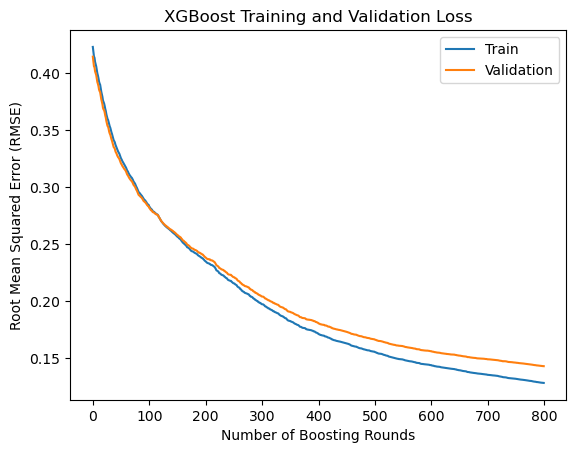

In [424]:
# # Extract the training and validation results from the dictionary
train_results = evals_result['train']['rmse']
val_results = evals_result['valid']['rmse']

# Plot the training and validation loss graph
plt.plot(train_results, label='Train')
plt.plot(val_results, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.show()

In [425]:
X_test.sort_index(inplace=True)
Y_test.sort_index(inplace=True)
pred_valid_xgboost = xgboost_advanced_model.predict(xgb.DMatrix(X_test))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

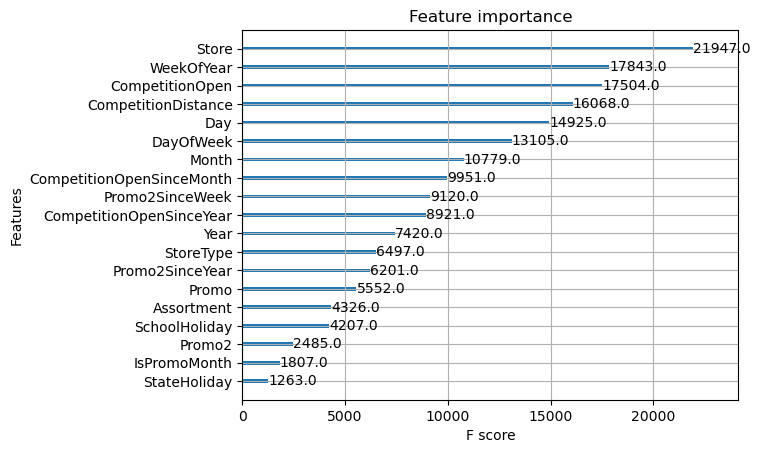

In [426]:
xgb.plot_importance(xgboost_advanced_model)

In [427]:
from sklearn.metrics import mean_absolute_error
# Print the R-squared score
r_squared_xgboost = r2_score(Y_test, pred_valid_xgboost)
print(f'R-squared (R²) score: {r_squared_xgboost:.4f}')
# Mean Squared Error (MSE)
xgboost_mse = mean_squared_error(Y_test, pred_valid_xgboost)
print(f"Mean Squared Error (MSE): {xgboost_mse:.4}")

mape_result_sklearn = mean_absolute_error(Y_test, pred_valid_xgboost) * 100
print(f"Mean Absolute Percentage Error (MAPE) : {mape_result_sklearn:.4}%")

# Root Mean Squared Error (RMSE)
xgboost_rmse = np.sqrt(xgboost_mse)
print(f"Root Mean Squared Error (RMSE): {xgboost_rmse:.4}")

R-squared (R²) score: 0.8815
Mean Squared Error (MSE): 0.0205
Mean Absolute Percentage Error (MAPE) : 10.96%
Root Mean Squared Error (RMSE): 0.1432


In [428]:
params_opt_cv = {
    "objective": "reg:squarederror",
    "booster" : "gbtree",
    "min_child_weight": 1,
    "eta": 0.03,
    "max_depth": 8,
    "subsample": 0.9,
    "colsample_bytree": 0.5,
    "seed": 42,
    "n_estimators": 800
}

# Create XGBoost regressor
cv_xgboost_model = xgb.XGBRegressor(**params_opt_cv)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store results
rmse_scores = []
mape_scores = []
forecast_biases = []
num_boost_round_opt = 0  # Initialize to 0

# Lists to store training and validation loss
train_losses = []
valid_losses = []

# Cross-validation loop
for train_idx, test_idx in tscv.split(X_train):
    X_train_cross, X_test_cross = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cross, y_test_cross = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

    # Train the model
    cv_xgboost_model.fit(
        X_train_cross, y_train_cross,
        eval_set=[(X_train_cross, y_train_cross), (X_test_cross, y_test_cross)],
        early_stopping_rounds=10,
        eval_metric="rmse",  # Specify the evaluation metric
        verbose=True
    )

    # Get the training and validation loss
    evals_result = cv_xgboost_model.evals_result()
    train_loss = evals_result['validation_0']['rmse']
    valid_loss = evals_result['validation_1']['rmse']

    # Store the training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Make predictions
    y_pred_cross = cv_xgboost_model.predict(X_test_cross)

    # Calculate RMSE
    rmse_cross = np.sqrt(mean_squared_error(y_test_cross, y_pred_cross))
    rmse_scores.append(rmse_cross)

    # Calculate MAPE
    mape_cross = mean_absolute_error(y_test_cross, y_pred_cross) * 100
    mape_scores.append(mape_cross)

    # Calculate Forecast Bias
    forecast_bias_cross = np.mean(y_test_cross - y_pred_cross)
    forecast_biases.append(forecast_bias_cross)

    # Get the optimal number of boosting rounds based on early stopping
    optimal_boost_rounds = cv_xgboost_model.best_iteration
    print(optimal_boost_rounds)
    num_boost_round_opt += optimal_boost_rounds  # Accumulate for later averaging

# Calculate the mean of the optimal number of boosting rounds
num_boost_round_opt = int(np.ceil(num_boost_round_opt / tscv.n_splits))
print(num_boost_round_opt)

# Display results
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

print("\nCross-Validation MAPE Scores:", mape_scores)
print("Average MAPE:", np.mean(mape_scores))

print("\nForecast Biases:", forecast_biases)
print("Average Forecast Bias:", np.mean(forecast_biases))

# Display training and validation loss
# print("\nTraining Losses:", train_losses
# print("Validation Losses:", valid_losses)


[0]	validation_0-rmse:0.40759	validation_1-rmse:0.42504
[1]	validation_0-rmse:0.40372	validation_1-rmse:0.42154
[2]	validation_0-rmse:0.39993	validation_1-rmse:0.41826
[3]	validation_0-rmse:0.39872	validation_1-rmse:0.41746
[4]	validation_0-rmse:0.39512	validation_1-rmse:0.41425


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[5]	validation_0-rmse:0.39259	validation_1-rmse:0.41268
[6]	validation_0-rmse:0.39010	validation_1-rmse:0.41153
[7]	validation_0-rmse:0.38697	validation_1-rmse:0.40917
[8]	validation_0-rmse:0.38422	validation_1-rmse:0.40671
[9]	validation_0-rmse:0.38175	validation_1-rmse:0.40555
[10]	validation_0-rmse:0.37924	validation_1-rmse:0.40419
[11]	validation_0-rmse:0.37649	validation_1-rmse:0.40210
[12]	validation_0-rmse:0.37457	validation_1-rmse:0.40135
[13]	validation_0-rmse:0.37308	validation_1-rmse:0.40057
[14]	validation_0-rmse:0.36996	validation_1-rmse:0.39750
[15]	validation_0-rmse:0.36704	validation_1-rmse:0.39476
[16]	validation_0-rmse:0.36502	validation_1-rmse:0.39332
[17]	validation_0-rmse:0.36271	validation_1-rmse:0.39116
[18]	validation_0-rmse:0.35974	validation_1-rmse:0.38824
[19]	validation_0-rmse:0.35810	validation_1-rmse:0.38725
[20]	validation_0-rmse:0.35650	validation_1-rmse:0.38631
[21]	validation_0-rmse:0.35443	validation_1-rmse:0.38446
[22]	validation_0-rmse:0.35201	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[3]	validation_0-rmse:0.40700	validation_1-rmse:0.40978
[4]	validation_0-rmse:0.40344	validation_1-rmse:0.40615
[5]	validation_0-rmse:0.40093	validation_1-rmse:0.40457
[6]	validation_0-rmse:0.39856	validation_1-rmse:0.40318
[7]	validation_0-rmse:0.39531	validation_1-rmse:0.40001
[8]	validation_0-rmse:0.39236	validation_1-rmse:0.39702
[9]	validation_0-rmse:0.39013	validation_1-rmse:0.39562
[10]	validation_0-rmse:0.38784	validation_1-rmse:0.39376
[11]	validation_0-rmse:0.38498	validation_1-rmse:0.39088
[12]	validation_0-rmse:0.38301	validation_1-rmse:0.38923
[13]	validation_0-rmse:0.38160	validation_1-rmse:0.38823
[14]	validation_0-rmse:0.37868	validation_1-rmse:0.38508
[15]	validation_0-rmse:0.37603	validation_1-rmse:0.38238
[16]	validation_0-rmse:0.37378	validation_1-rmse:0.38068
[17]	validation_0-rmse:0.37154	validation_1-rmse:0.37852
[18]	validation_0-rmse:0.36846	validation_1-rmse:0.37532
[19]	validation_0-rmse:0.36681	validation_1-rmse:0.37435
[20]	validation_0-rmse:0.36527	validat

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[3]	validation_0-rmse:0.40773	validation_1-rmse:0.42343
[4]	validation_0-rmse:0.40411	validation_1-rmse:0.41996
[5]	validation_0-rmse:0.40190	validation_1-rmse:0.41811
[6]	validation_0-rmse:0.39967	validation_1-rmse:0.41596
[7]	validation_0-rmse:0.39639	validation_1-rmse:0.41280
[8]	validation_0-rmse:0.39363	validation_1-rmse:0.41015
[9]	validation_0-rmse:0.39165	validation_1-rmse:0.40840
[10]	validation_0-rmse:0.38917	validation_1-rmse:0.40597
[11]	validation_0-rmse:0.38630	validation_1-rmse:0.40329
[12]	validation_0-rmse:0.38449	validation_1-rmse:0.40178
[13]	validation_0-rmse:0.38324	validation_1-rmse:0.40040
[14]	validation_0-rmse:0.38008	validation_1-rmse:0.39736
[15]	validation_0-rmse:0.37733	validation_1-rmse:0.39459
[16]	validation_0-rmse:0.37482	validation_1-rmse:0.39231
[17]	validation_0-rmse:0.37271	validation_1-rmse:0.39033
[18]	validation_0-rmse:0.36963	validation_1-rmse:0.38740
[19]	validation_0-rmse:0.36823	validation_1-rmse:0.38597
[20]	validation_0-rmse:0.36689	validat

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[2]	validation_0-rmse:0.41286	validation_1-rmse:0.41255
[3]	validation_0-rmse:0.41160	validation_1-rmse:0.41146
[4]	validation_0-rmse:0.40799	validation_1-rmse:0.40805
[5]	validation_0-rmse:0.40554	validation_1-rmse:0.40668
[6]	validation_0-rmse:0.40338	validation_1-rmse:0.40570
[7]	validation_0-rmse:0.39999	validation_1-rmse:0.40266
[8]	validation_0-rmse:0.39713	validation_1-rmse:0.40008
[9]	validation_0-rmse:0.39503	validation_1-rmse:0.39890
[10]	validation_0-rmse:0.39253	validation_1-rmse:0.39711
[11]	validation_0-rmse:0.38957	validation_1-rmse:0.39433
[12]	validation_0-rmse:0.38782	validation_1-rmse:0.39310
[13]	validation_0-rmse:0.38654	validation_1-rmse:0.39216
[14]	validation_0-rmse:0.38340	validation_1-rmse:0.38889
[15]	validation_0-rmse:0.38064	validation_1-rmse:0.38614
[16]	validation_0-rmse:0.37812	validation_1-rmse:0.38421
[17]	validation_0-rmse:0.37606	validation_1-rmse:0.38226
[18]	validation_0-rmse:0.37299	validation_1-rmse:0.37915
[19]	validation_0-rmse:0.37145	validati

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[2]	validation_0-rmse:0.41242	validation_1-rmse:0.42866
[3]	validation_0-rmse:0.41120	validation_1-rmse:0.42749
[4]	validation_0-rmse:0.40756	validation_1-rmse:0.42419
[5]	validation_0-rmse:0.40537	validation_1-rmse:0.42276
[6]	validation_0-rmse:0.40339	validation_1-rmse:0.42171
[7]	validation_0-rmse:0.40009	validation_1-rmse:0.41894
[8]	validation_0-rmse:0.39716	validation_1-rmse:0.41647
[9]	validation_0-rmse:0.39535	validation_1-rmse:0.41561
[10]	validation_0-rmse:0.39293	validation_1-rmse:0.41384
[11]	validation_0-rmse:0.38999	validation_1-rmse:0.41127
[12]	validation_0-rmse:0.38825	validation_1-rmse:0.40986
[13]	validation_0-rmse:0.38704	validation_1-rmse:0.40905
[14]	validation_0-rmse:0.38376	validation_1-rmse:0.40583
[15]	validation_0-rmse:0.38097	validation_1-rmse:0.40316
[16]	validation_0-rmse:0.37854	validation_1-rmse:0.40148
[17]	validation_0-rmse:0.37643	validation_1-rmse:0.39957
[18]	validation_0-rmse:0.37321	validation_1-rmse:0.39647
[19]	validation_0-rmse:0.37184	validati

In [429]:
# Assuming X_train and y_train are your training data and labels

# Create an XGBoost regressor
xgb_model_best_params_finder = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree'],
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [8, 10, 12],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'seed': [42]
}

# Create a time series cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5)

# Define the evaluation metric 
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create GridSearchCV object
grid_search = GridSearchCV(
    xgb_model_best_params_finder, param_grid, scoring=scorer,
    cv=tscv, verbose=1, n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, Y_train)

# Display the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'booster': 'gbtree', 'colsample_bytree': 0.6, 'eta': 0.05, 'max_depth': 12, 'objective': 'reg:squarederror', 'seed': 42, 'subsample': 0.9}


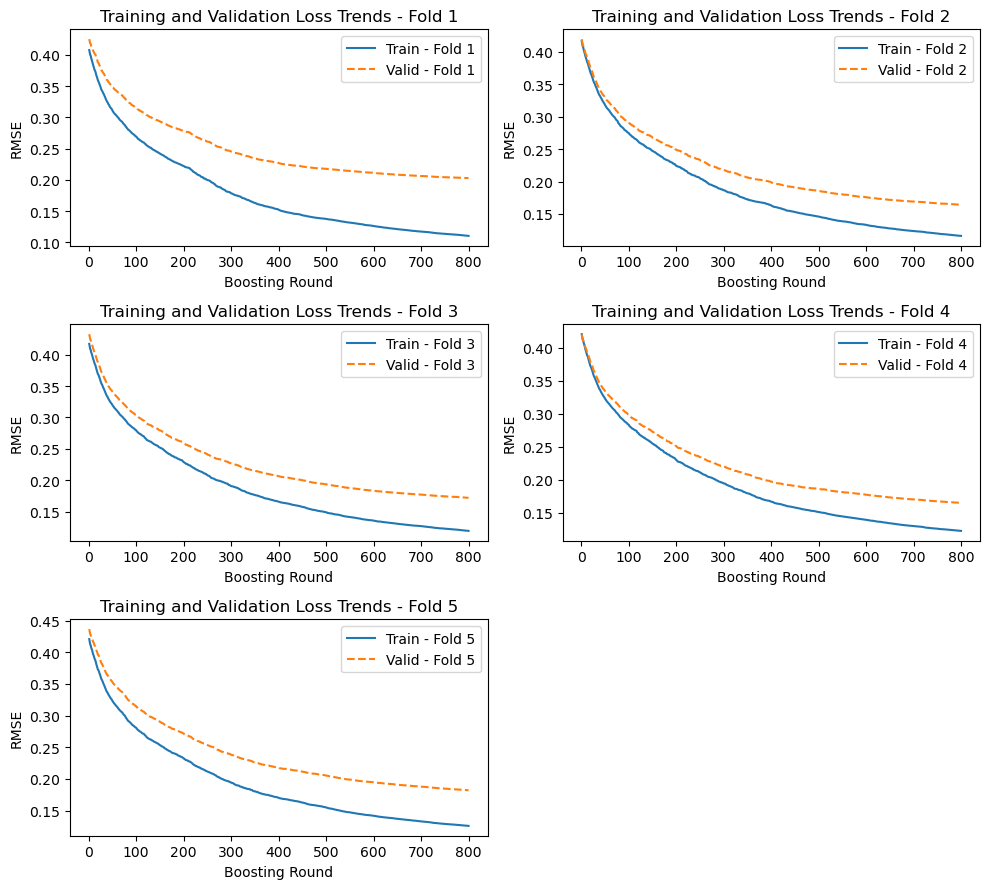

In [430]:
# Assuming all lists have the same length
num_boost_rounds = len(train_losses[0])

# Calculate the number of rows and columns needed
num_folds = len(train_losses)
num_rows = (num_folds + 1) // 2  # Round up in case of an odd number of folds
num_cols = 2 if num_folds > 1 else 1  # Show two subplots in each row if there are more than one fold

# Set up subplots with the calculated rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3 * num_rows))

# Plot for each fold
for i, ax in enumerate(axes.flat):
    if i < num_folds:
        ax.plot(range(1, num_boost_rounds + 1), train_losses[i], label=f'Train - Fold {i + 1}')
        ax.plot(range(1, num_boost_rounds + 1), valid_losses[i], label=f'Valid - Fold {i + 1}', linestyle='dashed')

        ax.set_xlabel('Boosting Round')
        ax.set_ylabel('RMSE')
        ax.set_title(f'Training and Validation Loss Trends - Fold {i + 1}')
        ax.legend()
        
# Remove the 6th subplot if it exists
if num_folds == 5:
    fig.delaxes(axes.flat[-1])

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

In [431]:
best_xgboost_model_predictions = cv_xgboost_model.predict(X_test)
best_xgboost_model_predictions

array([8.648003, 8.588764, 8.510554, ..., 8.873513, 8.893469, 9.07773 ],
      dtype=float32)

R-squared (R²) score: 0.8820
Mean Squared Error (MSE): 0.02041
Mean Absolute Percentage Error (MAPE) : 10.91%
Root Mean Squared Error (RMSE): 0.1432


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

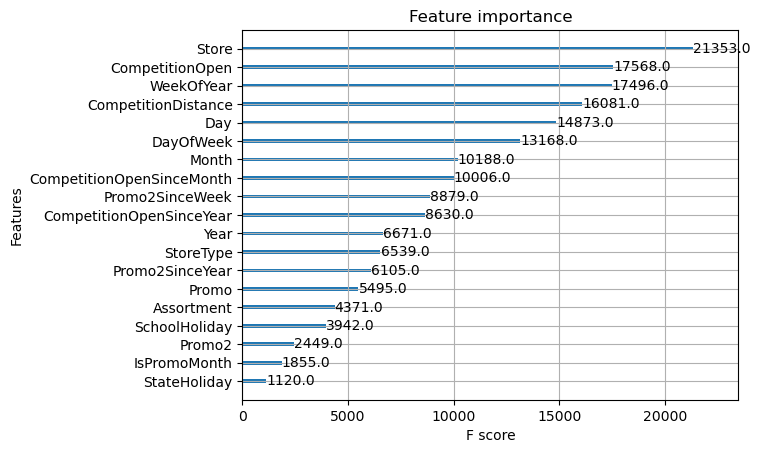

In [432]:
# from sklearn.metrics import mean_absolute_error
# Print the R-squared score
print(f'R-squared (R²) score: {r2_score(Y_test, best_xgboost_model_predictions):.4f}')
# Mean Squared Error (MSE)
print(f"Mean Squared Error (MSE): {mean_squared_error(Y_test, best_xgboost_model_predictions):.4}")
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_error(Y_test, best_xgboost_model_predictions) * 100:.4}%")
# Root Mean Squared Error (RMSE)
print(f"Root Mean Squared Error (RMSE): {np.sqrt(xgboost_mse):.4}")

xgb.plot_importance(cv_xgboost_model)

# # Assuming you have X_train and ho_ytrain for the entire training dataset
# best_model_optimal_params = cv_xgboost_model.get_params()
# num_boost_round_opt

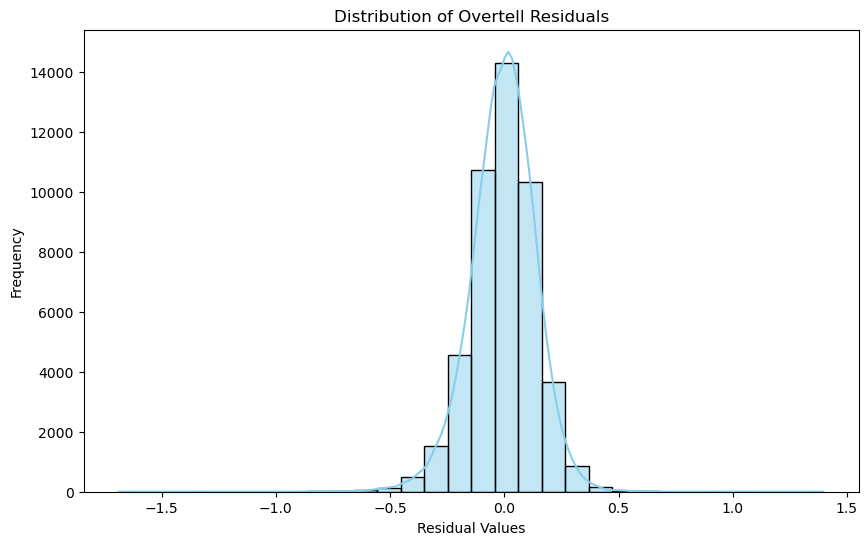

In [433]:
# Calculate residuals
residuals = Y_test - pred_valid_xgboost
# Specify the path where you want to save the CSV file

# Residual Plot
# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Overtell Residuals')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.show()
# print(residuals.mean())

In [434]:
# Mean
mean_value = np.mean(residuals)
print(f"Mean: {mean_value}")
# Standard Deviation
std_deviation = np.std(residuals)
print(f"Standard Deviation: {std_deviation}")

# Skewness
skewness_value = skew(residuals)
print(f"Skewness: {skewness_value}")

# Kurtosis
kurtosis_value = kurtosis(residuals)
print(f"Kurtosis: {kurtosis_value}")

Mean: -0.0046739438256809445
Standard Deviation: 0.1430900215025592
Skewness: -0.3021687621080842
Kurtosis: 2.633299123149981


# Part D - Train LSTM Model

In [435]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the LSTM model
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [437]:
# # Build the baseline LSTM model
# baseline_lstm = Sequential()
# baseline_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
# baseline_lstm.add(Dense(1))
# baseline_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

# # Train the baseline LSTM model
# baseline_lstm.fit(X_train_reshaped, Y_train, epochs=50, batch_size=16, validation_data=(X_test_reshaped, Y_test), verbose=2)

# # Make predictions
# Y_pred_baseline = baseline_lstm.predict(X_test)

# # Evaluate the baseline LSTM model using RMSE
# rmse_baseline_lstm = np.sqrt(mean_squared_error(Y_test, Y_pred_baseline))

# print(f'Baseline LSTM Model RMSE: {rmse_baseline_lstm:.2f}')

In [438]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

In [ ]:
# Train the model
# Fit LSTM model
epochs=10
history = lstm_model.fit(X_train_reshaped, Y_train, epochs=epochs, batch_size=50, validation_data=(X_test_reshaped, Y_test))

# Evaluate the model
loss = lstm_model.evaluate(X_test_reshaped, Y_test)
print(f'Model Test Loss: {loss}')

Epoch 1/10
 1500/15949 [=>............................] - ETA: 4:43 - loss: 1.6279 - rmse: 0.9065

In [ ]:
lstm_model.summary()

In [ ]:
# Plot training and validation RMSE
train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

epochs = np.arange(1, len(train_rmse) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Training RMSE')
plt.plot(epochs, val_rmse, label='Validation RMSE')
plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
train_rmse

In [ ]:
# Evaluate the LSTM model
pred_valid_lstm = lstm_model.predict(X_test_reshaped)

In [ ]:
# Print the R-squared score
r_squared_lstm = r2_score(Y_test, pred_valid_lstm)
print(f'R-squared (R²) score: {r_squared_lstm:.4f}')
# Mean Squared Error (MSE)
lstm_mse = mean_squared_error(Y_test, pred_valid_lstm)
print(f"Mean Squared Error (MSE): {lstm_mse}")

mape_result_lstm = mean_absolute_error(Y_test, pred_valid_lstm) * 100
print(f"Mean Absolute Percentage Error (MAPE) : {mape_result_lstm:.4}%")

# Root Mean Squared Error (RMSE)
lstm_rmse = np.sqrt(lstm_mse)
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")

In [ ]:
pred_valid_lstm

In [ ]:
X_train

# Part E - Evaluation

In [ ]:
# Assuming y_test contains the real data
# Create an array with the corresponding indices
indices = np.arange(len(Y_test[-50:]))

# Plot the real data and predicted data
plt.figure(figsize=(15, 9))
plt.plot(indices, np.expm1(Y_test[-50:]), label='Real Data', marker='o')
plt.plot(indices, np.expm1(pred_valid_xgboost[-50:]), label='Predicted Data', marker='x')

# Customize the plot
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real Data vs. Predicted Data (xgboost)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
np.expm1(Y_test[-50:])

In [ ]:
# Assuming y_test contains the real data
# Create an array with the corresponding indices
indices = np.arange(len(Y_test[-50:]))

# Plot the real data and predicted data
plt.figure(figsize=(15, 9))
plt.plot(np.arange(len(Y_test[-50:])), np.expm1(Y_test[-50:]), label='Real Data', marker='o')
plt.plot(np.arange(len(pred_valid_lstm[-50:])), np.expm1(pred_valid_lstm[-50:]), label='Predicted Data', marker='x')

# Customize the plot
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real Data vs. Predicted Data (LSTM)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Calculate forecast bias for xgboost
forecast_bias_xgboost = np.mean(Y_test - pred_valid_xgboost)
print(f"Forecast Bias xgboost: {forecast_bias_xgboost}")

In [ ]:
from tabulate import tabulate

# Create a table
table = [
    ["Metric", "Xgboost", "LSTM"],
    ["R-squared (R²)", r_squared_xgboost, r_squared_lstm],
    ["MAPE", mape_result_sklearn, mape_result_lstm],
    ["RMSE", xgboost_rmse, lstm_rmse]
]

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

In [ ]:
xtest_analysis = X_test.copy()
xtest_analysis['actual_sales'] = np.expm1(Y_test)
xtest_analysis['predicted_sales'] = np.expm1(pred_valid_xgboost)
# xtest_analysis.describe().T

promo_active_predictions = xtest_analysis[xtest_analysis['Promo'] == 1]['predicted_sales']
promo_inactive_predictions = xtest_analysis[xtest_analysis['Promo'] == 0]['predicted_sales']

# Compare the predicted sales using t-test
t_stat, p_value = ttest_ind(promo_active_predictions, promo_inactive_predictions)
print(f'T-test p-value: {p_value}')

sns.boxplot(x='Promo', y='predicted_sales', data=xtest_analysis)
plt.title('Predicted Sales Comparison during Promo and Non-Promo Periods')
plt.show()

In [ ]:
#X_test, test_Data
test_final = test_all.copy()
test_final.drop(['Id'],axis=1,inplace =True)

In [ ]:
#foreast xgoost
dtest_future_dates = xgb.DMatrix(test_final)
future_preds_xgboost = xgboost_advanced_model.predict(dtest_future_dates)
future_preds_xgboost

In [ ]:
test_final_scaled = scaler.transform(test_final)
# Reshape the data for the LSTM model
test_final_scaled_reshaped = test_final_scaled.reshape((test_final_scaled.shape[0], test_final_scaled.shape[1], 1))
# Evaluate the LSTM model
future_preds_lstm = lstm_model.predict(test_final_scaled_reshaped)
future_preds_lstm

In [ ]:
# Convert columns to integers
# Create an empty list to store date objects
date_objects = []

# Loop through each row in the DataFrame
for index, row in test_final.iterrows():
#     year = row['Year'].astype(int)
#     month = row['Month'].astype(int)
#     day = row['Day'].astype(int)
    year = row['Year']
    month = row['Month']
    day = row['Day']
    # datetime(year, month, day)
    # Create a date object and append to the list
    date_objects.append(datetime(year, month, day))


# Add the date_objects list as a new column to your DataFrame
test_final['generated_date'] = date_objects

In [ ]:
# Convert columns to integers
# Create an empty list to store date objects
date_objects = []

# Loop through each row in the DataFrame
for index, row in X_test.iterrows():
#     year = row['Year'].astype(int)
#     month = row['Month'].astype(int)
#     day = row['Day'].astype(int)
    year = row['Year']
    month = row['Month']
    day = row['Day']
    # datetime(year, month, day)
    # Create a date object and append to the list
    date_objects.append(datetime(year, month, day))


# Add the date_objects list as a new column to your DataFrame
X_test['generated_date'] = date_objects

In [ ]:
test_final['predicted_sales_xgboost'] = np.expm1(future_preds_xgboost)
test_final['predicted_sales_lstm'] = np.expm1(future_preds_lstm)
X_test['actual_sales'] = np.expm1(Y_test.values)
X_test[-100:]

In [ ]:
xgboost_output = future_preds_xgboost[-50:].copy()
# xgboost_output[0] = Y_test.iloc[-1]
#remove this block before submitting
np.expm1(Y_test[-50:])

In [ ]:
# Assuming y_test contains the real validation data
# Assuming pred_valid_xgboost contains the predicted validation data
indices_valid = np.arange(len(Y_test[-50:]))

# Create an array with the corresponding indices for the forecasted future dates
indices_forecast = np.arange(len(Y_test[-50:]), len(Y_test[-50:]) + len(xgboost_output))
# indices_forecast = indices_valid + len(future_preds_xgboost)

# Plot the forecasted future dates
plt.figure(figsize=(15, 9))
plt.plot(indices_valid, np.expm1(Y_test[-50:]), label='Real Validation Data', marker='o')
plt.plot(indices_valid, np.expm1(pred_valid_xgboost[-50:]), label='Predicted Validation Data', marker='x')
plt.plot(indices_forecast, np.expm1(xgboost_output), label='Forecasted Future Data', marker='s')

# Customize the plot for the forecasted future dates
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real Validation Data, Predicted Validation Data, and Forecasted Future Data (XGBoost)')
plt.legend()
plt.grid(True)

# Show the plot for the forecasted future dates
plt.show()

In [ ]:
# Assuming y_test contains the real validation data
# Assuming pred_valid_xgboost contains the predicted validation data
indices_valid = np.arange(len(Y_test[-50:]))

# Create an array with the corresponding indices for the forecasted future dates
indices_forecast = np.arange(len(Y_test[-50:]), len(Y_test[-50:]) + len(future_preds_lstm[-50:]))
# indices_forecast = indices_valid + len(future_preds_xgboost)

# Plot the forecasted future dates
plt.figure(figsize=(15, 9))
plt.plot(indices_valid, np.expm1(Y_test[-50:]), label='Real Validation Data', marker='o')
plt.plot(indices_valid, np.expm1(pred_valid_xgboost[-50:]), label='Predicted Validation Data', marker='x')
plt.plot(indices_forecast, np.expm1(future_preds_lstm[-50:]), label='Forecasted Future Data', marker='s')

# Customize the plot for the forecasted future dates
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real Validation Data, Predicted Validation Data, and Forecasted Future Data (LSTM)')
plt.legend()
plt.grid(True)

# Show the plot for the forecasted future dates
plt.show()

In [ ]:
valid_info = pd.DataFrame(data = np.expm1(Y_test))
valid_info['Pred'] = np.expm1(pred_valid_xgboost)
valid_info = pd.merge(X_test,valid_info, left_index= True, right_index=True)
valid_info['Ratio'] = valid_info.Pred/valid_info.Sales
valid_info['Error'] = abs(valid_info.Ratio-1)
valid_info['RelError'] = (valid_info.Ratio-1)
valid_info['Weight'] = valid_info.Sales/valid_info.Pred
valid_info.head()[['Sales','Pred','Ratio','Error','RelError','Weight']]

In [ ]:
import random
# stores = [random.choice(range(1,1116,1)) for i in range(3)]
stores = [615,1033,913]

for s in stores:
    store = pd.DataFrame(valid_info[valid_info['Store']==s],columns = ['Sales','Pred'])
    store.plot(title = 'store {}'.format(s),figsize=(12,3))

In [ ]:
all_stores = set(range(1, 1116, 1))
excluded_stores = {615, 1033, 913}
remaining_stores = list(all_stores - excluded_stores)

selected_stores = random.sample(remaining_stores, 10)

for s in selected_stores:
    store = pd.DataFrame(valid_info[valid_info['Store'] == s], columns=['Sales', 'Pred'])
    store.plot(title='Store {}'.format(s), figsize=(12, 3))

In [ ]:
for s in stores:
    store_information = xtest_analysis[xtest_analysis['Store'] == s]
    promo_active_store_info = store_information[store_information['Promo'] == 1]
    promo_inactive_info = store_information[store_information['Promo'] == 0]

    # Display the results
    print(f"\nMean Actual Sales While Active Promo for {s}: {promo_active_store_info['actual_sales'].mean()}")
    print(f"Standard Deviation Actual Sales While Active Promo for {s}: {promo_active_store_info['actual_sales'].std()}")
    print(f"Mean Predicted Sales While Active Promo for {s}: {promo_active_store_info['predicted_sales'].mean()}")
    print(f"Standard Deviation Predicted Sales While Active Promo for {s}: {promo_active_store_info['predicted_sales'].std()}")

    # Display the results
    print(f"\nMean Actual Sales While Inactive Promo for {s}: {promo_inactive_info['actual_sales'].mean()}")
    print(f"Standard Deviation Actual Sales While Inactive Promo for {s}: {promo_inactive_info['actual_sales'].std()}")
    print(f"Mean Predicted Sales While Inactive Promo for {s}: {promo_inactive_info['predicted_sales'].mean()}")
    print(f"Standard Deviation Predicted Sales While Inactive Promo for {s}: {promo_inactive_info['predicted_sales'].std()}")

In [ ]:
# Calculate the overall mean of CompetitionDistance
overall_average_competition_distance = xtest_analysis['CompetitionDistance'].mean()

# Create empty lists to store information for below and above average
below_average_stores = []
above_average_stores = []

# Iterate through each store
for s in stores:
    store_information = xtest_analysis[xtest_analysis['Store'] == s]
    
    # Calculate the mean of CompetitionDistance for the specific store
    store_average_competition_distance = store_information['CompetitionDistance'].mean()
    
    # Categorize the store based on the average
    if store_average_competition_distance < overall_average_competition_distance:
        print(f"\nMean Actual Sales While Competition is nearbly than average for {s}: {store_information['actual_sales'].mean()}")
        print(f"\nMean Predicted Sales While Competition is nearbly than average for {s}: {store_information['predicted_sales'].mean()}")
    else:
        print(f"\nMean Actual Sales While Competition is away than average for {s}: {store_information['actual_sales'].mean()}")
        print(f"\nMean Predicted Sales While Competition is away  than average for {s}: {store_information['predicted_sales'].mean()}")

# # Display the results
# print(f"Stores with CompetitionDistance below average: {below_average_stores}")
# print(f"Stores with CompetitionDistance above average: {above_average_stores}")